# [보스턴 집값 예측] 

## **문제 정의**
* 보스턴 지역 지값 데이터를 이용하여 집 값에 영향을 미치는 요인을 분석하고 집 값을 예측하자.

## **필요 내용**
* EDA과정과 생각의 발전 과정을 기입.
* 모델에 대한 평가 수행.
* 모형 학습과정의 문서화.
---------------------------------------

## 0. 필요 library Import 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame,Series
import keras
from keras import layers
from keras import models
from keras.models import Model
from keras.layers import Dropout
from keras import regularizers
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from sklearn import datasets

Using TensorFlow backend.
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---------------------------------------

## 1. 데이터 로드 및 파싱

In [135]:
# column name 정의
column_names = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT',
    'MEDV'
]

In [136]:
# input 데이터 로드
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
data = pd.read_csv(url, sep='\s+', header = None, names = column_names )

In [137]:
# input 데이터 shape 확인
data.shape

(506, 14)

In [138]:
# input 데이터 확인
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


* 컬럼 정보 

    * CRIM - Town별 범죄 비율
    * ZN - 25,000피트를 넘는 거주지역 비율
    * INDUS - 비 상업지역의 비율
    * CHAS - 찰스강 강둑 주변이면 1, 아니면 0
    * NOX - 일산화 질수 수치
    * RM - 방 수
    * AGE - 1940년 이전에 건축된 주택 비율
    * DIS - 보스턴 직웝센터의 접근성
    * RAD - 고속도로 접근성
    * TAX - 재산세
    * PTRATION - 학생 / 교사 비율
    * B - 흑인 비율
    * LSTAT - 하층민 비율
    * MEDV - 주택 가격
    

---------------------------------------

## 2. 기반 모델 선정 하기
* 목적 : Regression 문제를 풀 수 있는 모델 중 어떤 모델을 선정할지에 대한 후보군 추출 POC

### 2.1 EDA
### 2.1.1 기초적인 데이터 확인

In [139]:
# input 데이터 null 체크
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [140]:
# input 데이터 타입 확인
data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

In [141]:
# input 데이터 unique 여부 확인
data.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
MEDV       229
dtype: int64

### 2.1.2 데이터의 분포 확인
* 목적 : 데이터의 분포를 통해 Feature별 특성 확인

In [142]:
# input 데이터 기초 통계량
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


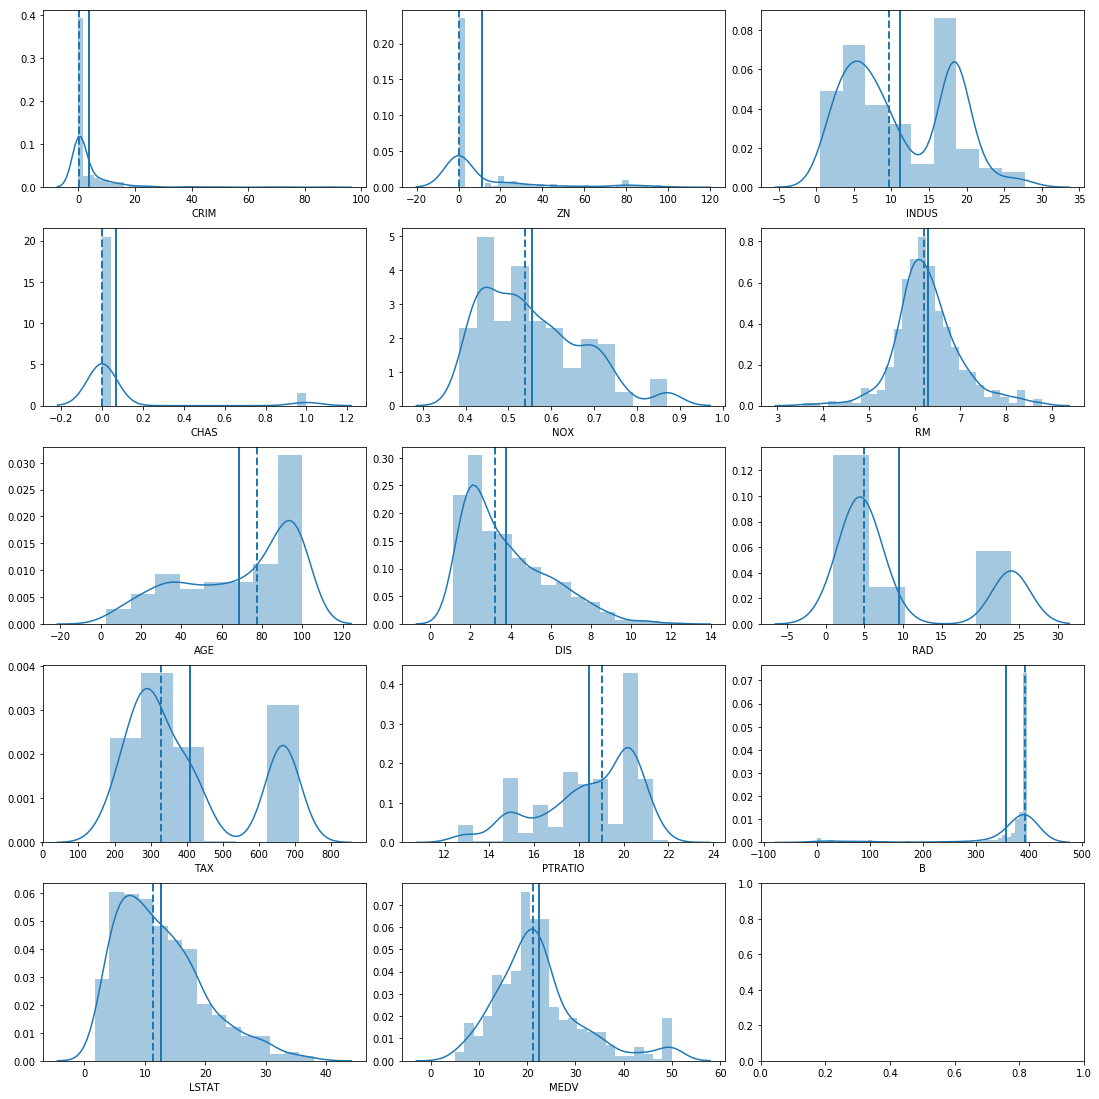

In [10]:
# input data feature 별 데이터의 분포

width = 3
height = 5

axes = plt.subplots(height,width,figsize=(15,15))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

for i in range(0,len(column_names)):
        plt.subplot(height,width, i+1)
        sns.distplot(data[column_names[i]])
        plt.axvline(data[column_names[i]].mean(), linestyle='solid', linewidth=2)
        plt.axvline(data[column_names[i]].median(), linestyle='dashed', linewidth=2)

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


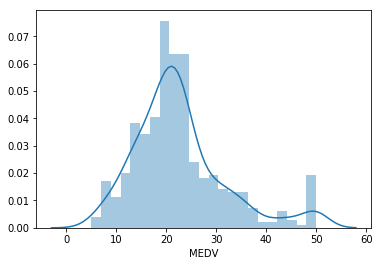

In [11]:
sns.distplot(data['MEDV'])

### 데이터 분포 확인 결과
* MEDV와 RM Feature의 경우 정규 분포 형태로 데이터가 분포함.
* 회기 분석 목적으로 정규분포로 변경 가능한 데이터들은 정규 분포와 유사하게 변형 필요.
* CRIM, ZN, B의 경우 지나치게 Skew 되어 있기 때문에 별도로 의미를 파악하는 것이 필요.
* INDUS,NOX,RAD,TAX,PTRATIO 도 특정 값에 치우져져 있는 형태를 보임. 확인 필요.

### 2.2 Featrue Scaling
* 목적 : 데이터의 분포만으로는 학습에 필요한 데이터의 경향성을 파악하기 힘들기 때문에 3종류의 input feature를 만들고 선행적으로 POC 모델들의 예측 결과를 통해 적절한 input 형태를 결정하기 위함.
* 데이터 전처리 종류
    * raw 데이터
    * raw 데이터 Standardization
    * raw 데이터 Normalization
* 3종류의 Input Data의 학습 결과를 통해 Input feature 선정.

In [143]:
base_data = data.copy()

In [144]:
# 전체 데이터 random shuffle
# 학습 시 동일 결과에 대한 비교 목적으로 사전에 suffle 수행
base_data = base_data.sample(frac=1.0, random_state=13)

In [145]:
# 학습데이터와 검증용 데이터 셋 구분을 위한 key 생성
base_data['key'] = base_data.index

In [146]:
# Input data standardization

binary_column = ['CHAS']
std_column = ['CRIM','ZN','INDUS','PTRATIO','LSTAT','NOX','RM','DIS','RAD','TAX','B','AGE', 'MEDV']

std_data = base_data.copy()

for column_name in binary_column:
    std_data[column_name] = std_data[column_name] 

for column_name in std_column:
    std_data[column_name] = (std_data[column_name] - std_data[column_name].mean()) /  std_data[column_name].std() 

In [147]:
# Input data Normaliation

binary_column = ['CHAS']
normalizaed_column = ['CRIM','ZN','INDUS','PTRATIO','LSTAT','NOX','RM','DIS','RAD','TAX','B','AGE', 'MEDV']

scale_data = base_data.copy()

for column_name in binary_column:
    scale_data[column_name] = scale_data[column_name] 

# 비율 데이터가 아닌 경우 Normaliation ( 0 ~ 1 Scailing)
for column_name in normalizaed_column:
    scale_data[column_name] = (scale_data[column_name] - scale_data[column_name].min()) /  (scale_data[column_name].max() - scale_data[column_name].min() )

In [148]:
std_data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,key
count,5.060000e+02,5.060000e+02,5.060000e+02,506.000000,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,506.000000
mean,-7.723291e-17,3.686116e-17,2.808469e-17,0.069170,-2.141458e-16,1.162004e-15,3.422822e-16,-9.829643e-17,5.265880e-17,2.808469e-17,-3.931857e-16,-1.035623e-16,1.825505e-16,-1.334023e-16,252.500000
std,1.000000e+00,1.000000e+00,1.000000e+00,0.253994,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,146.213884
min,-4.193669e-01,-4.872402e-01,-1.556302e+00,0.000000,-1.464433e+00,-3.876413e+00,-2.333128e+00,-1.265817e+00,-9.818712e-01,-1.312691e+00,-2.704703e+00,-3.903331e+00,-1.529613e+00,-1.906340e+00,0.000000
25%,-4.105633e-01,-4.872402e-01,-8.668328e-01,0.000000,-9.121262e-01,-5.680681e-01,-8.366200e-01,-8.048913e-01,-6.373311e-01,-7.668172e-01,-4.875567e-01,2.048688e-01,-7.986296e-01,-5.988631e-01,126.250000
50%,-3.902803e-01,-4.872402e-01,-2.108898e-01,0.000000,-1.440749e-01,-1.083583e-01,3.170678e-01,-2.790473e-01,-5.224844e-01,-4.642132e-01,2.745872e-01,3.808097e-01,-1.810744e-01,-1.449159e-01,252.500000
75%,7.389247e-03,4.872402e-02,1.014995e+00,0.000000,5.980871e-01,4.822906e-01,9.059016e-01,6.617161e-01,1.659603e+00,1.529413e+00,8.057784e-01,4.332223e-01,6.024226e-01,2.682577e-01,378.750000
max,9.924110e+00,3.800473e+00,2.420170e+00,1.000000,2.729645e+00,3.551530e+00,1.116390e+00,3.956602e+00,1.659603e+00,1.796416e+00,1.637208e+00,4.406159e-01,3.545262e+00,2.986505e+00,505.000000


In [149]:
scale_data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,key
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.040544,0.113636,0.391378,0.069170,0.349167,0.521869,0.676364,0.242381,0.371713,0.422208,0.622929,0.898568,0.301409,0.389618,252.500000
std,0.096679,0.233225,0.251479,0.253994,0.238431,0.134627,0.289896,0.191482,0.378576,0.321636,0.230313,0.230205,0.197049,0.204380,146.213884
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000851,0.000000,0.173387,0.000000,0.131687,0.445392,0.433831,0.088259,0.130435,0.175573,0.510638,0.945730,0.144040,0.267222,126.250000
50%,0.002812,0.000000,0.338343,0.000000,0.314815,0.507281,0.768280,0.188949,0.173913,0.272901,0.686170,0.986232,0.265728,0.360000,252.500000
75%,0.041258,0.125000,0.646628,0.000000,0.491770,0.586798,0.938980,0.369088,1.000000,0.914122,0.808511,0.998298,0.420116,0.444444,378.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,505.000000


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


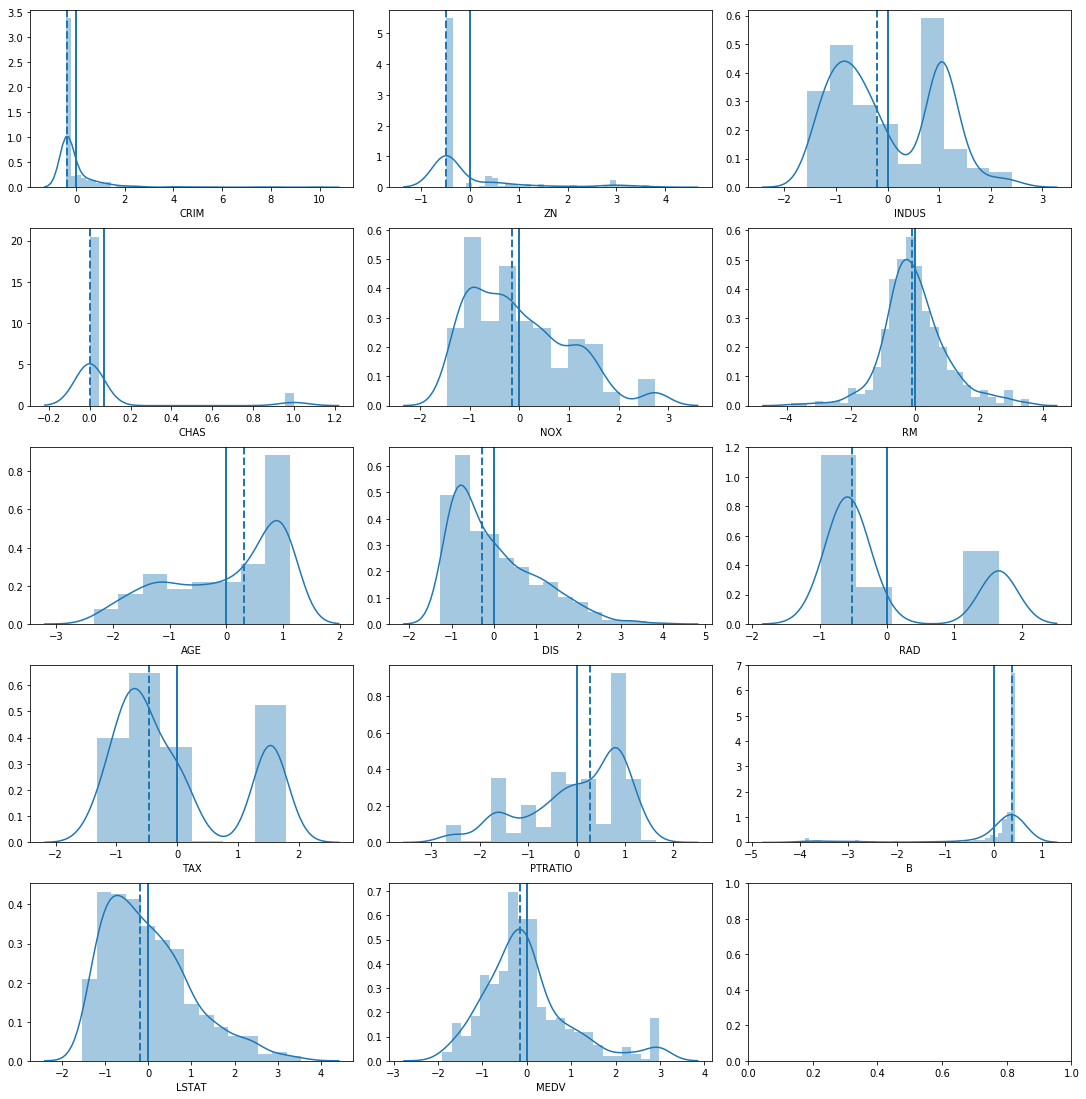

In [150]:
#  standardization input data feature 별 데이터의 분포

width = 3
height = 5

axes = plt.subplots(height,width,figsize=(15,15))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

for i in range(0,len(column_names)):
        plt.subplot(height,width, i+1)
        sns.distplot(std_data[column_names[i]])
        plt.axvline(std_data[column_names[i]].mean(), linestyle='solid', linewidth=2)
        plt.axvline(std_data[column_names[i]].median(), linestyle='dashed', linewidth=2)


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


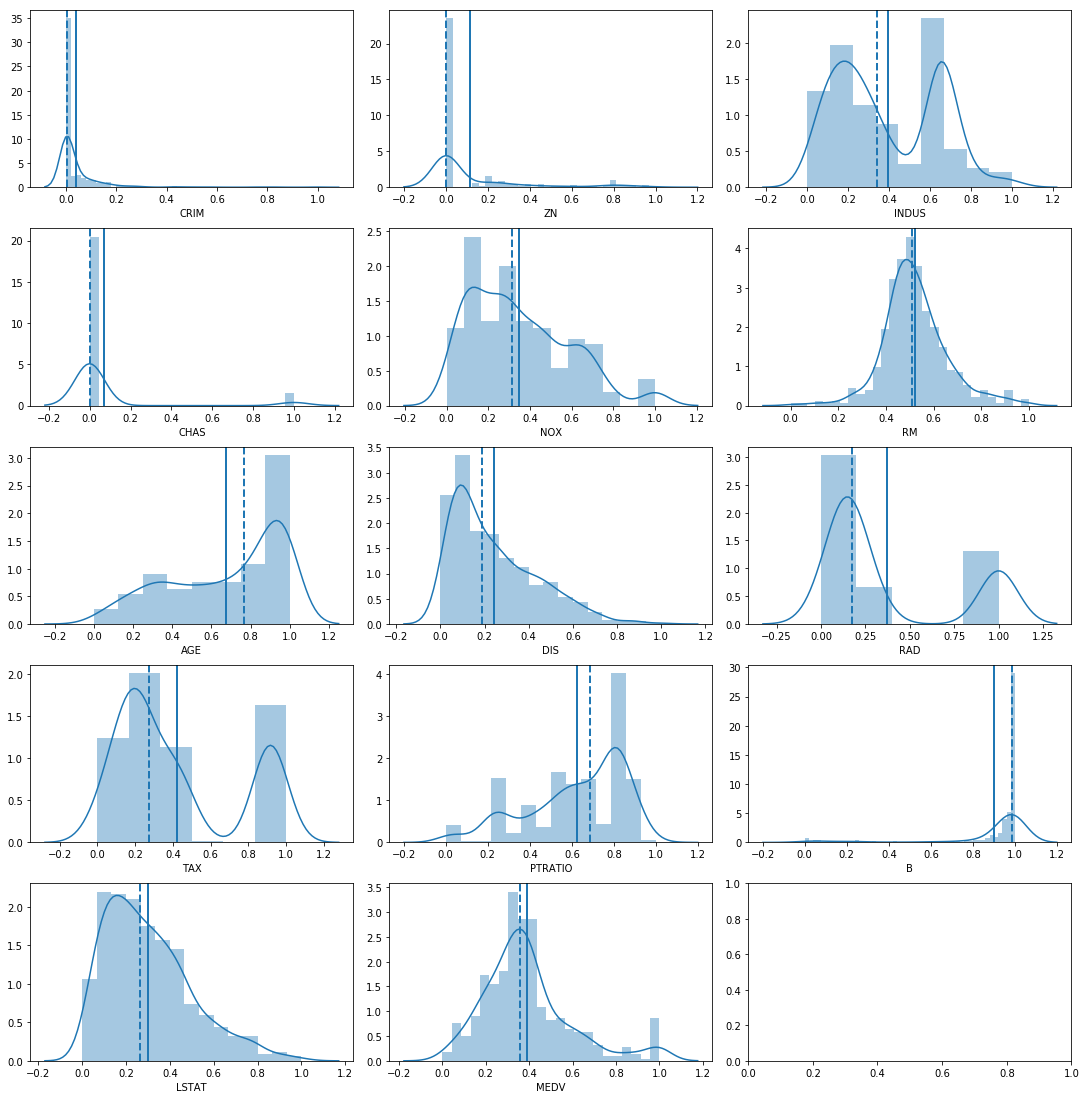

In [20]:
#  Normalization input data feature 별 데이터의 분포

width = 3
height = 5

axes = plt.subplots(height,width,figsize=(15,15))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

for i in range(0,len(column_names)):
        plt.subplot(height,width, i+1)
        sns.distplot(scale_data[column_names[i]])
        plt.axvline(scale_data[column_names[i]].mean(), linestyle='solid', linewidth=2)
        plt.axvline(scale_data[column_names[i]].median(), linestyle='dashed', linewidth=2)


### 2.3 학습 데이터 셋 / 평가 데이터 셋 분리
* 목적 : 모든 모델의 학습 데이터 셋과 테스트 데이터 셋이 동일해야 동등 비교가 되기 때문에 각 input종류별로 동일한 데이터를 구성
* train data set - 전체 데이터 셋의 80%
* test data set - 전체 데이터 셋의 20%
* 데이터 셋 자제가 506개로 매우 적기 때문에 상위 기준으로 결정

In [151]:
train_data = base_data[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','key']] 
train_targets = base_data[['MEDV']]

X_train_base, X_test_base, Y_train_base, Y_test_base = train_test_split(train_data, train_targets, test_size = 0.2, random_state = 13)

In [152]:
print(X_train_base.shape)
print(Y_train_base.shape)
print(X_test_base.shape)
print(Y_test_base.shape)

(404, 14)
(404, 1)
(102, 14)
(102, 1)


In [153]:
X_train_std=pd.merge(X_train_base[['key']], std_data[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','key']] , on='key')
Y_train_std=pd.merge(X_train_base[['key']], std_data[['MEDV', 'key']] , on='key')
X_test_std=pd.merge(X_test_base[['key']], std_data[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','key']] , on='key')
Y_test_std=pd.merge(X_test_base[['key']], std_data[['MEDV', 'key']] , on='key')

In [154]:
print(X_train_std.shape)
print(Y_train_std.shape)
print(X_test_std.shape)
print(Y_test_std.shape)

(404, 14)
(404, 2)
(102, 14)
(102, 2)


In [155]:
X_train_scale=pd.merge(X_train_base[['key']], scale_data[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','key']] , on='key')
Y_train_scale=pd.merge(X_train_base[['key']], scale_data[['MEDV', 'key']] , on='key')
X_test_scale=pd.merge(X_test_base[['key']], scale_data[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','key']] , on='key')
Y_test_scale=pd.merge(X_test_base[['key']], scale_data[['MEDV', 'key']] , on='key')

In [156]:
print(X_train_scale.shape)
print(Y_train_scale.shape)
print(X_test_scale.shape)
print(Y_test_scale.shape)

(404, 14)
(404, 2)
(102, 14)
(102, 2)


In [157]:
X_train_scale.head()

,key,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,214,0.003183,0.00,0.371334,0,0.213992,0.354666,0.071061,0.223508,0.130435,0.171756,0.638298,0.879041,0.767660
1,63,0.001351,0.25,0.171188,0,0.139918,0.613336,0.417096,0.623021,0.304348,0.185115,0.755319,0.996672,0.214404
2,348,0.000098,0.80,0.056818,0,0.102881,0.589002,0.276004,0.656039,0.130435,0.177481,0.468085,0.984972,0.117550
3,264,0.006112,0.20,0.128666,0,0.539095,0.698410,0.913491,0.072793,0.173913,0.146947,0.042553,0.977281,0.175773
4,186,0.000559,0.00,0.073314,0,0.211934,0.818164,0.522142,0.188198,0.086957,0.011450,0.553191,0.989233,0.075055


In [158]:
X_train_std.head()

,key,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,214,-0.386439,-0.487240,-0.079701,0,-0.566935,-1.241977,-2.088003,-0.098562,-0.637331,-0.778684,0.066730,-0.084824,2.366166
1,63,-0.405395,0.584688,-0.875579,0,-0.877607,0.679411,-0.894349,1.987860,-0.177944,-0.737150,0.574826,0.426157,-0.441540
2,348,-0.418357,2.942931,-1.330366,0,-1.032943,0.498658,-1.381047,2.160296,-0.637331,-0.760884,-0.672319,0.375333,-0.933063
3,264,-0.356152,0.370303,-1.044666,0,0.796572,1.311334,0.817976,-0.885660,-0.522484,-0.855818,-2.519940,0.341925,-0.637589
4,186,-0.413589,-0.487240,-1.264771,0,-0.575564,2.200865,-0.531990,-0.282965,-0.752178,-1.277091,-0.302794,0.393844,-1.148718


### 2.4 POC 모델 만들기
* 목적
    * 하위 알고리즘들을 통해 어떤 형태의 데이터를 input feature로 선정할지 기준을 찾기 위함
    * 하위 알고리즘들을 통해 알고리즘의 선택 및 개선점 기준을 잡기 위함
* 알고리즘 종류
    * Linear Regression
    * Decision TreeRegression
    * GradientBoost Regression
    * RandomForest Regeression
    * Deep Neural Network Regression

In [29]:
def dnn_model(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(13, activation='relu',input_dim = 13))
    model.add(layers.Dense(13, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [30]:
def dnn_model_1(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_dim = 13))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [31]:
folds   = 4
metric  = "mean_squared_error"

# hold different regression models in a single dictionary
model_dict = {}
model_dict["Linear"]        = LinearRegression()
model_dict["DecisionTree"]  = DecisionTreeRegressor()
model_dict["GradientBoost"] = GradientBoostingRegressor()
model_dict["RandomForest"]  = RandomForestRegressor()
model_dict["DNN_1"] = KerasRegressor(build_fn=dnn_model, epochs=400, batch_size=16,verbose=0)
model_dict["DNN_2"] = KerasRegressor(build_fn=dnn_model_1, epochs=400, batch_size=16,verbose=0)

In [32]:
model_results = []
model_names   = []
for model_name in model_dict:
    model   = model_dict[model_name]
    k_fold  = KFold(n_splits=folds, random_state=1)
    results = cross_val_score(model, X_train_base.drop(columns=['key']), Y_train_base, cv=k_fold, scoring=metric)

    model_results.append(results)
    model_names.append(model_name)
    print("{}: {}".format(model_name, round(results.mean(), 5)))

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

Linear: -26.38962
DecisionTree: -23.07153


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was

GradientBoost: -12.07172
RandomForest: -15.16923


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_1: -26.79927


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


DNN_2: -49.82777


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


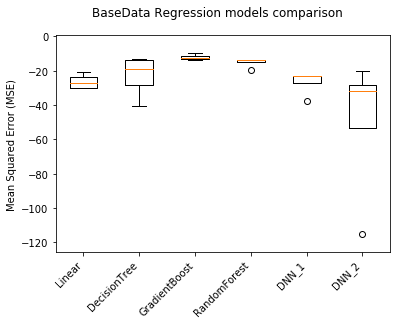

In [34]:
figure = plt.figure()
figure.suptitle('BaseData Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(model_results)
axis.set_xticklabels(model_names, rotation = 45, ha="right")
axis.set_ylabel("Mean Squared Error (MSE)")
plt.margins(0.05, 0.1)
plt.show()

In [35]:
model_results = []
model_names   = []
for model_name in model_dict:
    model   = model_dict[model_name]
    k_fold  = KFold(n_splits=folds, random_state=1)
    results = cross_val_score(model, X_train_std.drop(columns=['key']), Y_train_std.drop(columns=['key']), cv=k_fold, scoring=metric)

    model_results.append(results)
    model_names.append(model_name)
    print("{}: {}".format(model_name, round(results.mean(), 5)))

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

Linear: -0.31198
DecisionTree: -0.25751
GradientBoost: -0.14129


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was

RandomForest: -0.19728


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_1: -0.19624


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_2: -0.17647


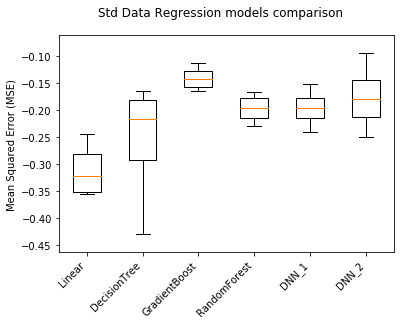

In [36]:
figure = plt.figure()
figure.suptitle('Std Data Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(model_results)
axis.set_xticklabels(model_names, rotation = 45, ha="right")
axis.set_ylabel("Mean Squared Error (MSE)")
plt.margins(0.05, 0.1)
plt.show()

In [37]:
model_results = []
model_names   = []
for model_name in model_dict:
    model   = model_dict[model_name]
    k_fold  = KFold(n_splits=folds, random_state=1)
    results = cross_val_score(model, X_train_scale.drop(columns=['key']), Y_train_scale.drop(columns=['key']), cv=k_fold, scoring=metric)

    model_results.append(results)
    model_names.append(model_name)
    print("{}: {}".format(model_name, round(results.mean(), 5)))


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

Linear: -0.01303
DecisionTree: -0.01134
GradientBoost: -0.00628


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was

RandomForest: -0.00839


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_1: -0.00852


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_2: -0.00727


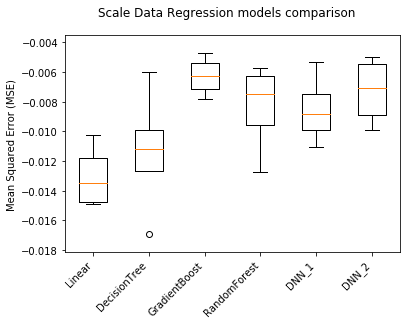

In [38]:
figure = plt.figure()
figure.suptitle('Scale Data Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(model_results)
axis.set_xticklabels(model_names, rotation = 45, ha="right")
axis.set_ylabel("Mean Squared Error (MSE)")
plt.margins(0.05, 0.1)
plt.show()

### POC 모델 분석결과
* rawdata 자체를 input으로 쓰게 되면 각 feature별 편차가 크기 때문에 학습이 어려워 짐.
* 이에 대한 대안 
    * Standardization input or Normalization input
* 해당 대안을 섞어서도 사용할 수 있지만 한정된 작업 시간으로 인해 각각 진행.
* 해당 대안의 단점 
    * 학습 데이터 범위에 없는 데이터가 input으로 입력 시 재 분석 및 재 학습이 필요함.
* Normalization Input POC 모델간의 결과의 편차가 더 적음을 확인. 
* 추가적으로 Input Feature의 데이터에 비율에 대한 정보들이 50%정도를 이미 차지하고 있기 때문에 Normalization 데이터를 사용하기로 결정
* 5개의 모델중 성능이 좋은 Gradient Boost, DNN 모델을 선정하여 두 모델의 성능을 개선하여 비교하는 방향으로 작업 수행. 

-------------------------------------------------------------------

## 3. POC 모델 개선하기
### 3.1 EDA
* 목적: 모델 개선을 위해 집 값을 결정짓는 주요한 Feature를 선정하기 위함
### 3.1.1 Feature간 상관 관계

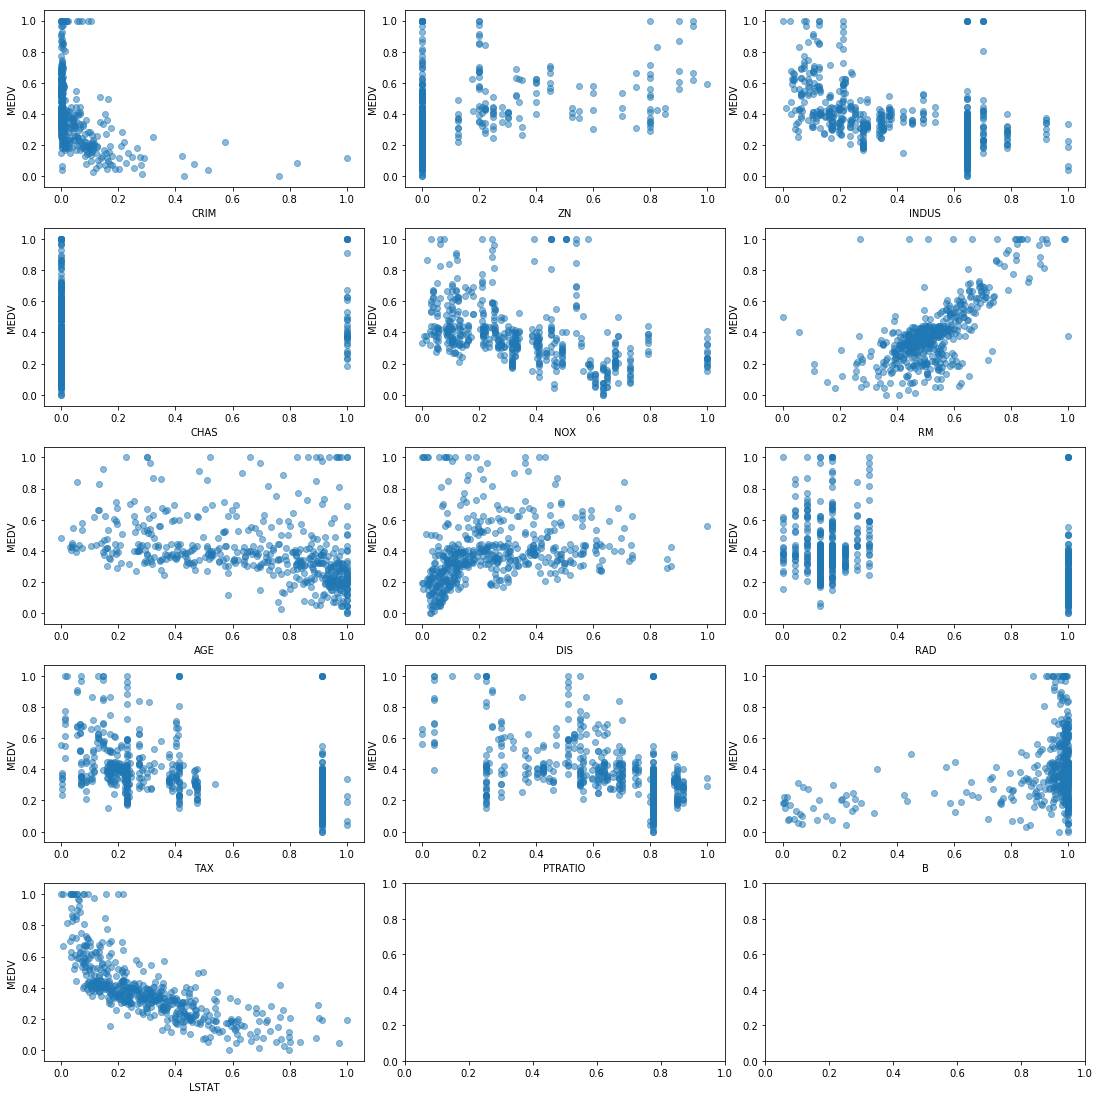

In [40]:
width = 3
height = 5

fig,axes = plt.subplots(height, width, figsize=(15,15))
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=2.0)

for i in range (0,height):
    for j in range (0,width):
        
        if ((i*width) + j == len(column_names) - 1): break
        
        axes[i][j].scatter(scale_data[column_names[(i*width) + j]],scale_data['MEDV'], alpha = 0.5)
        axes[i][j].set_xlabel(column_names[(i*width) + j])        
        axes[i][j].set_ylabel('MEDV')
        
plt.show()

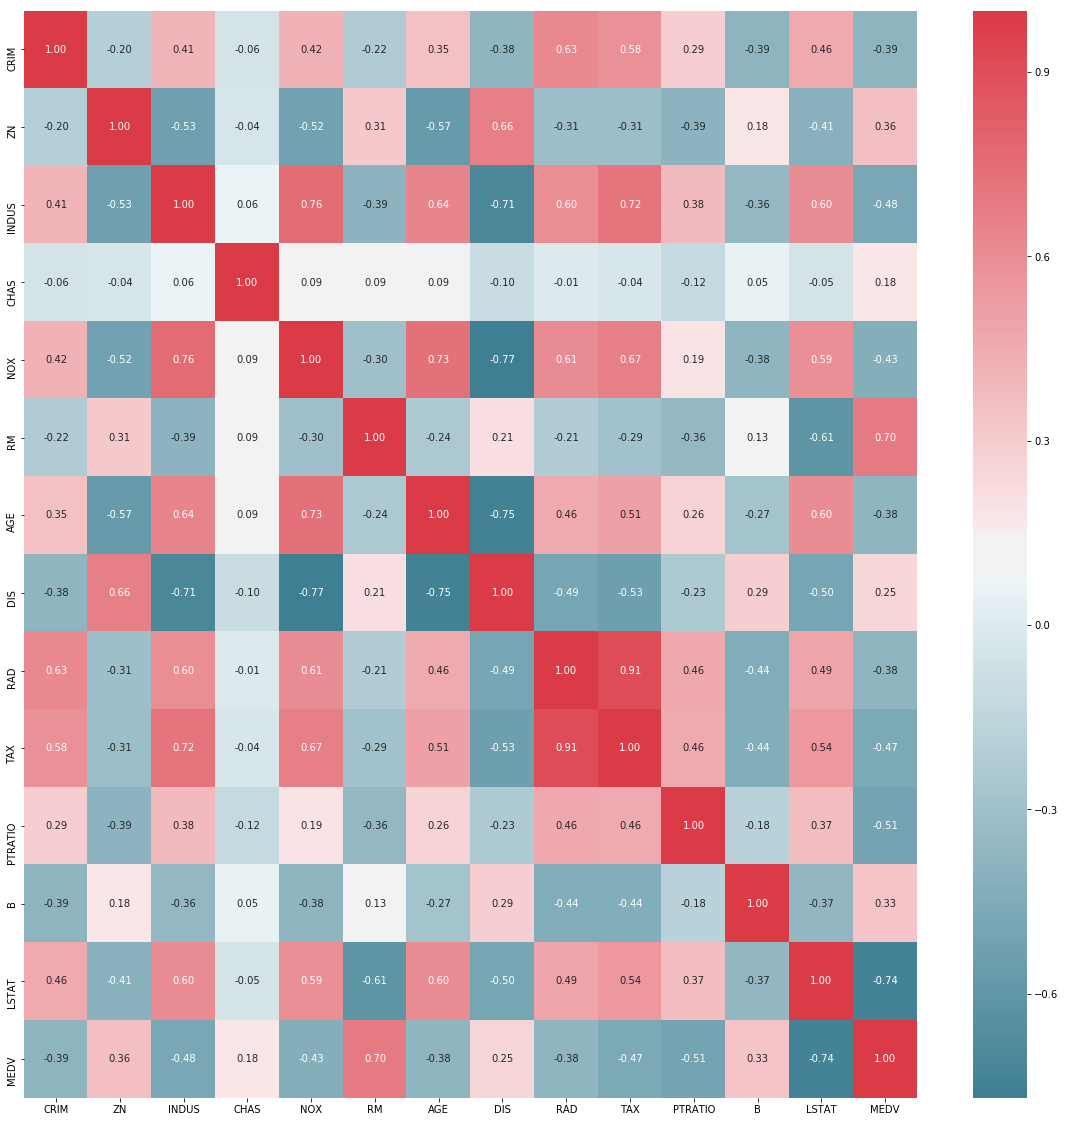

In [41]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(20,20))
sns.heatmap(scale_data.drop(columns=['key']).corr(), cmap=colormap, annot=True, fmt=".2f")

### 상관 관계가 높은 Feature의 분석 결과
* RM(방 수)의 경우 집 가격과 매우 밀접한 관련이 있음 (양의 상관 관계)
* PTRATIO(학생 교사 비율)의 경우 교사 한명당 학생 비율이 많으면 집 값이 떨어짐.(음의 상관 관계)
* LSTAT(하층민 비율)의 경우 비율이 많을 수록 집 값이 떨어짐.(음의 상관관계) 

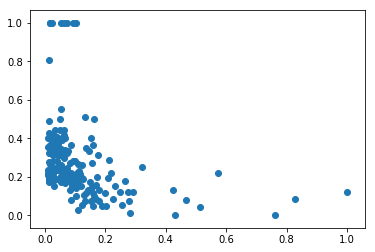

In [42]:
plt.scatter(x=scale_data[scale_data['CRIM']>0.01]['CRIM'],y=scale_data[scale_data['CRIM']>0.01]['MEDV'])

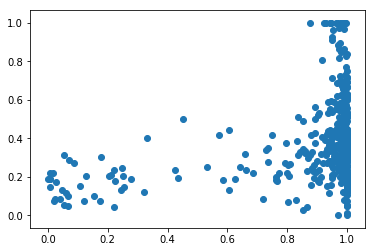

In [44]:
plt.scatter(x=scale_data['B'],y=scale_data['MEDV'])

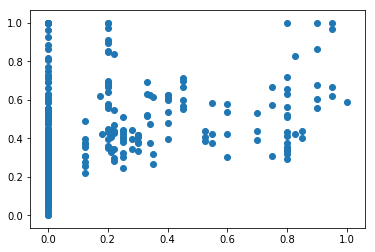

In [45]:
plt.scatter(x=scale_data['ZN'],y=scale_data['MEDV'])

### Skew Data와의 상관 관계 분석 결과
* CRIM(범죄율)이 0에 가까운 데이터를 제거 후 보면 범죄율에 따라 집 값이 음의 상관 관계를 보이는 것을 알 수 있음
* B(흑인비율) 또한 집 값에 영향을 주지 않는 것으로 보임.(대부분의 데이터가 비슷한 값에 분포 됨)
* ZN(지대가 높은 곳의 비율)의 경우 집값에 영향을 주지 않는 것으로 보임

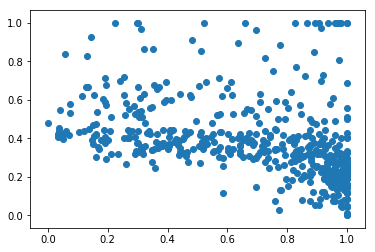

In [46]:
plt.scatter(x=scale_data['AGE'],y=scale_data['MEDV'])

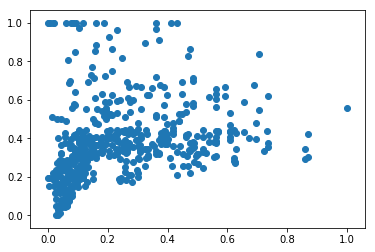

In [47]:
plt.scatter(x=scale_data['DIS'],y=scale_data['MEDV'])

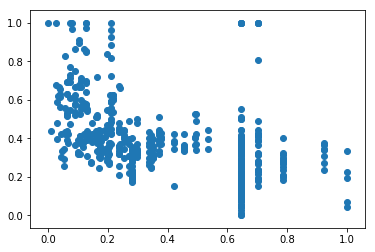

In [48]:
plt.scatter(x=scale_data['INDUS'],y=scale_data['MEDV'])

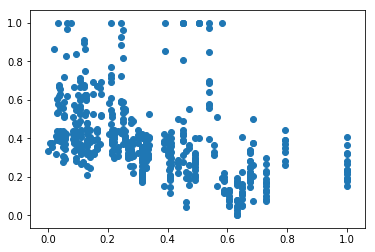

In [49]:
plt.scatter(x=scale_data['NOX'],y=scale_data['MEDV'])

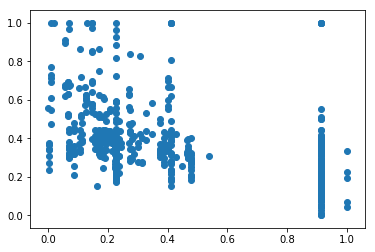

In [50]:
plt.scatter(x=scale_data['TAX'],y=scale_data['MEDV'])

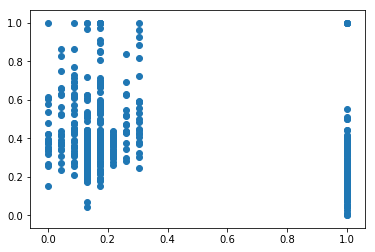

In [51]:
plt.scatter(x=scale_data['RAD'],y=scale_data['MEDV'])

### 나머지 Feature 상관 관계 분석
* AGE(오래된 주택 비율)의 경우 오래된 주택의 비율이 많을 수 록 집 값이 떨어지는 음의 상관 관계의 경향이 보임.
* DIS (직원 센터와의 접근성)의 경우 접근성이 좋을 수록 집 값이 올라가는 양의 상관 관계의 경향을 보임
* NOX의 경우 집값과 음의 상관 관계의 경향성을 보임.
* INDUS의 경우 집값과 음의 상관 관계의 경향성을 보임.
* TAX의 경우 집 값과 상관 관계를 보인다고 보기 어려움.
* RAD의 경우 집 값과 상관 관계를 보인다고 보기 어려움.

[INFO] MSE : 0.003


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


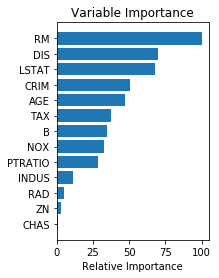

In [53]:
# create and fit the best regression model
boston = datasets.load_boston()

clf = GradientBoostingRegressor()
clf.fit( X_train_scale.drop(columns=['key']), Y_train_scale.drop(columns=['key']))
#mse = mean_squared_error(y_test, gbr_model.predict(X_test_scale.drop(columns=['key'])))

               
# make predictions using the model
predictions = clf.predict( X_test_scale.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error(Y_test_scale.drop(columns=['key']), predictions), 3)))


feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Gradient Boost의 Featrue Importance 분석
* RM, DIS, LSTAT, AGE, CRIM 이 TOP5로 집 값을 결정짓는 주요한 요소로 보임.

### 최종 결정 Featrue
* RM, LSTAT, PTRATIO, CRIM, INDUS, NOX, AGE, DIS

### 3.2 Feature Engineering
* 목적 : 최종 결정된 Feature를 회귀분석 표준 가정에 맞추기 위해 정규 분포와 유사하게 변형이 가능한 Feature는 정규분포로 변경
* 기존 Normalization Input Featrue와 정규분포로 변경된 Input간의 성능 비교를 수행.
* 심하게 skew된 데이터는 해당 변환에서 제외 (데이터의 의미를 왜곡하기 때문이라 판단)
    * skew 데이터의 경우 뒷 단계에서 튜닝 시 catecorical data로 변경해 볼 예정.

In [54]:
feature_column = ['RM','LSTAT','PTRATIO','CRIM','INDUS','NOX','AGE','DIS']

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


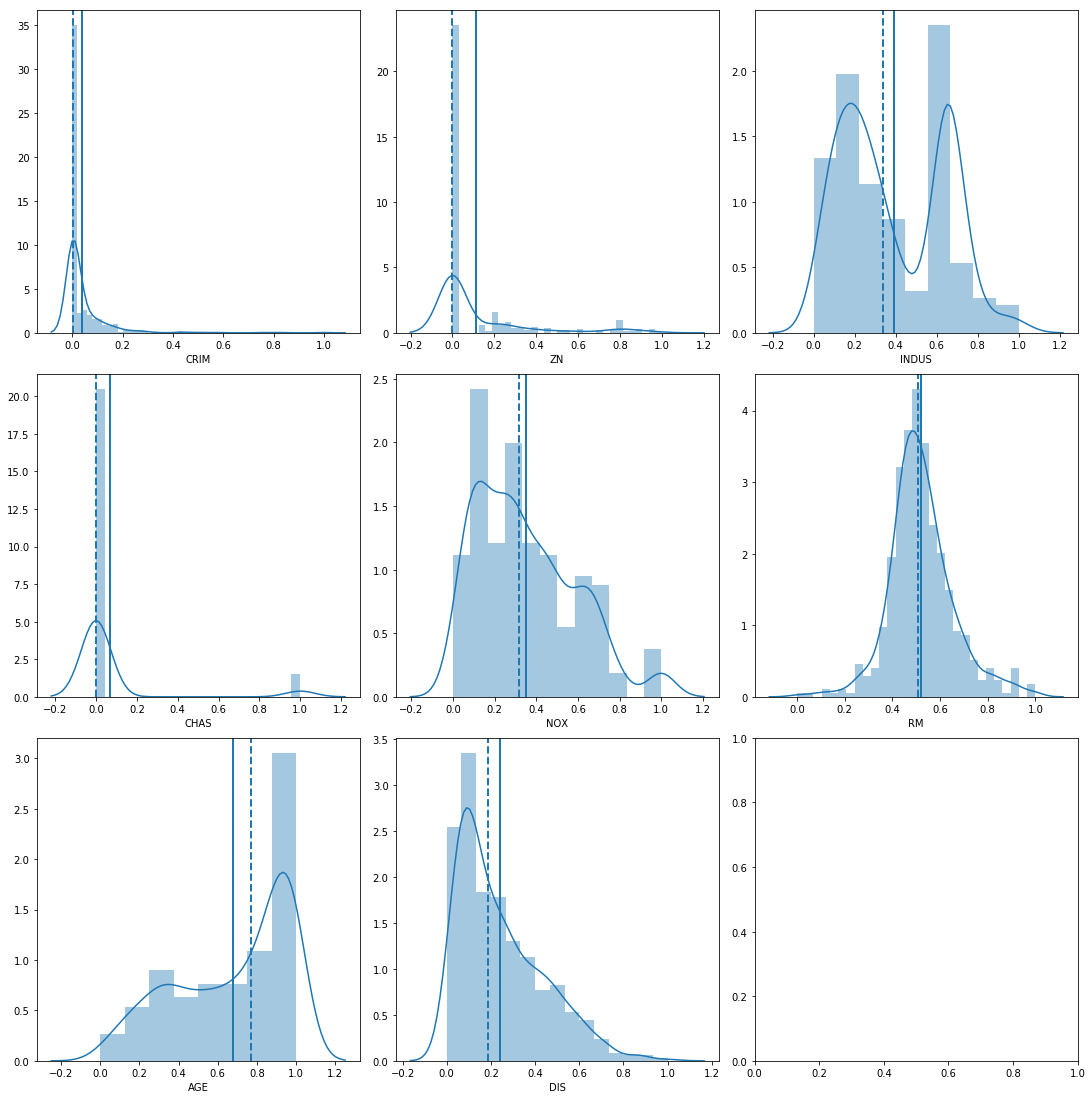

In [55]:
width = 3
height = 3

axes = plt.subplots(height,width,figsize=(15,15))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

for i in range(0,len(feature_column)):
        plt.subplot(height,width, i+1)
        sns.distplot(scale_data[column_names[i]])
        plt.axvline(scale_data[column_names[i]].mean(), linestyle='solid', linewidth=2)
        plt.axvline(scale_data[column_names[i]].median(), linestyle='dashed', linewidth=2)

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


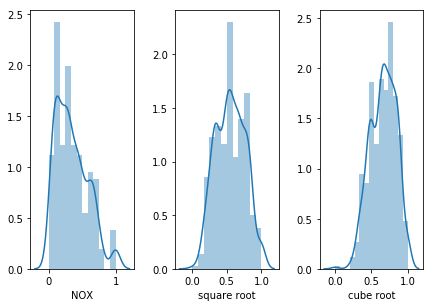

In [56]:
fig,axes = plt.subplots(1, 3)
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=2.0)

plt.subplot(1,3,1)
sns.distplot((scale_data['NOX']),axlabel = 'NOX')
plt.subplot(1,3,2)
sns.distplot(np.sqrt(scale_data['NOX']),axlabel = 'square root')
plt.subplot(1,3,3)
sns.distplot(np.cbrt(scale_data['NOX']),axlabel = 'cube root')

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


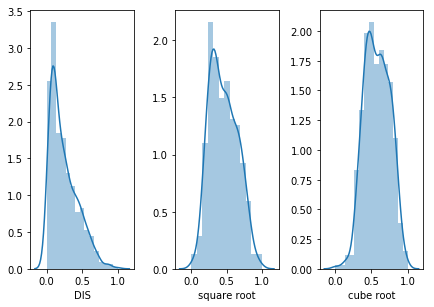

In [57]:
fig,axes = plt.subplots(1, 3)
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=2.0)

plt.subplot(1,3,1)
sns.distplot((scale_data['DIS']),axlabel = 'DIS')
plt.subplot(1,3,2)
sns.distplot(np.sqrt(scale_data['DIS']),axlabel = 'square root')
plt.subplot(1,3,3)
sns.distplot(np.cbrt(scale_data['DIS']),axlabel = 'cube root')

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


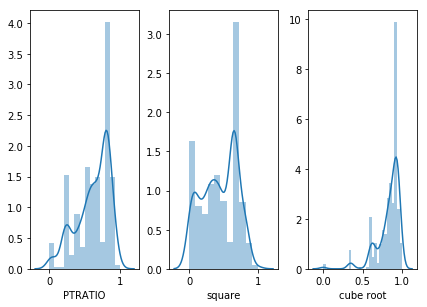

In [58]:
fig,axes = plt.subplots(2, 2)
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=2.0)

plt.subplot(1,3,1)
sns.distplot((scale_data['PTRATIO']),axlabel = 'PTRATIO')
plt.subplot(1,3,2)
sns.distplot(np.square(scale_data['PTRATIO']),axlabel = 'square')
plt.subplot(1,3,3)
sns.distplot(np.cbrt(scale_data['PTRATIO']),axlabel = 'cube root')

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


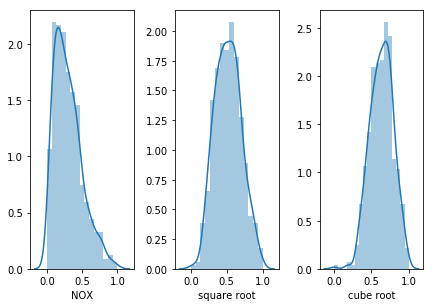

In [59]:
fig,axes = plt.subplots(1, 3)
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=2.0)

plt.subplot(1,3,1)
sns.distplot((scale_data['LSTAT']),axlabel = 'NOX')
plt.subplot(1,3,2)
sns.distplot(np.sqrt(scale_data['LSTAT']),axlabel = 'square root')
plt.subplot(1,3,3)
sns.distplot(np.cbrt(scale_data['LSTAT']),axlabel = 'cube root')

In [159]:
scale_trans_data = scale_data.copy()

scale_trans_data['DIS'] = np.cbrt(scale_trans_data['DIS']) 
scale_trans_data['AGE'] = np.square(scale_trans_data['AGE']) 
scale_trans_data['PTRATIO'] = np.square(scale_trans_data['PTRATIO']) 
scale_trans_data['LSTAT'] = np.cbrt(scale_trans_data['LSTAT'])
scale_trans_data['NOX'] = np.cbrt(scale_trans_data['NOX']) 

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


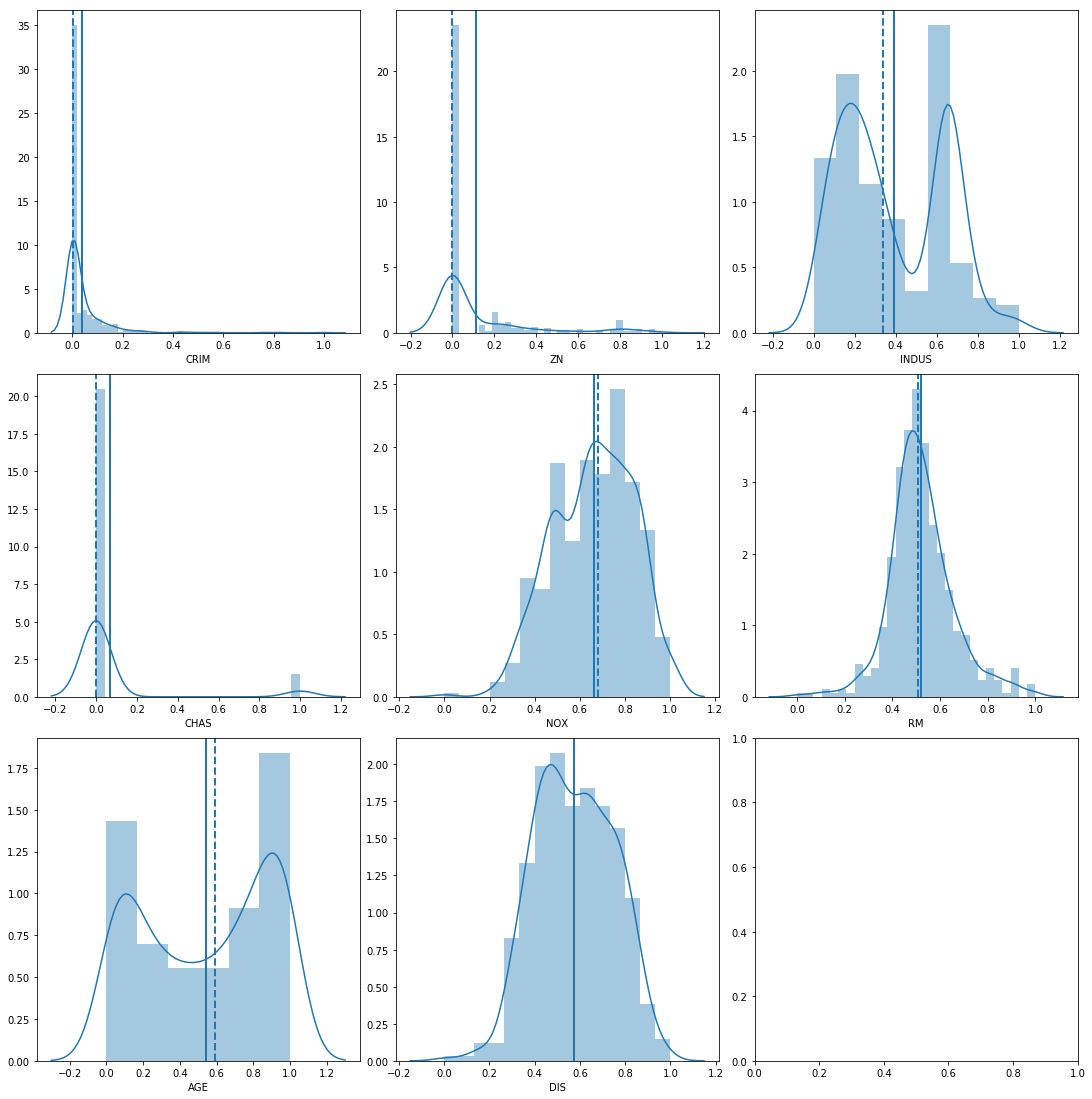

In [61]:
width = 3
height = 3

axes = plt.subplots(height,width,figsize=(15,15))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

for i in range(0,len(feature_column)):
        plt.subplot(height,width, i+1)
        sns.distplot(scale_trans_data[column_names[i]])
        plt.axvline(scale_trans_data[column_names[i]].mean(), linestyle='solid', linewidth=2)
        plt.axvline(scale_trans_data[column_names[i]].median(), linestyle='dashed', linewidth=2)


### 3.3 학습 데이터 셋 / 평가 데이터 셋 분리

In [160]:
X_train_selection_feature = X_train_scale[['RM','LSTAT','PTRATIO','CRIM','INDUS','NOX','AGE','DIS','key']]
Y_train_selection_feature = Y_train_scale[['MEDV','key']]
X_test_selection_feature = X_test_scale[['RM','LSTAT','PTRATIO','CRIM','INDUS','NOX','AGE','DIS','key']]
Y_test_selection_feature = Y_test_scale[['MEDV','key']]

In [161]:
print(X_train_selection_feature.shape)
print(Y_train_selection_feature.shape)
print(X_test_selection_feature.shape)
print(Y_test_selection_feature.shape)

(404, 9)
(404, 2)
(102, 9)
(102, 2)


In [162]:
X_train_selection_feature_ts =pd.merge(X_train_scale[['key']], scale_trans_data[['RM','LSTAT','PTRATIO','CRIM','INDUS','NOX','AGE','DIS','key']] , on='key')
Y_train_selection_feature_ts =pd.merge(X_train_scale[['key']], scale_trans_data[['MEDV','key']] , on='key')
X_test_selection_feature_ts =pd.merge(X_test_scale[['key']], scale_trans_data[['RM','LSTAT','PTRATIO','CRIM','INDUS','NOX','AGE','DIS','key']] , on='key')
Y_test_selection_feature_ts =pd.merge(X_test_scale[['key']], scale_trans_data[['MEDV','key']] , on='key')

In [163]:
print(X_train_selection_feature_ts.shape)
print(Y_train_selection_feature_ts.shape)
print(X_test_selection_feature_ts.shape)
print(Y_test_selection_feature_ts.shape)

(404, 9)
(404, 2)
(102, 9)
(102, 2)


In [26]:
def dnn_model_3(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_dim = 8))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [67]:
def dnn_model_4(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_dim = 8))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [68]:
def dnn_model_5(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_dim = 8))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [69]:
folds   = 4
metric  = "mean_squared_error"

# hold different regression models in a single dictionary
model_dict = {}
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
model_dict["GradientBoost"] = GradientBoostingRegressor(**params)
model_dict["DNN_1"] = KerasRegressor(build_fn=dnn_model_3, epochs=400, batch_size=16,verbose=0)
model_dict["DNN_2"] = KerasRegressor(build_fn=dnn_model_4, epochs=400, batch_size=16,verbose=0)
model_dict["DNN_3"] = KerasRegressor(build_fn=dnn_model_5, epochs=400, batch_size=16,verbose=0)

In [71]:
model_results = []
model_names   = []
for model_name in model_dict:
    model   = model_dict[model_name]
    k_fold  = KFold(n_splits=folds, random_state=1)
    results = cross_val_score(model, X_train_selection_feature.drop(columns=['key']), Y_train_selection_feature.drop(columns=['key']), cv=k_fold, scoring=metric)

    model_results.append(results)
    model_names.append(model_name)
    print("{}: {}".format(model_name, round(results.mean(), 5)))

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_

GradientBoost: -0.0063


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_1: -0.00745


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_2: -0.00714


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_3: -0.00691


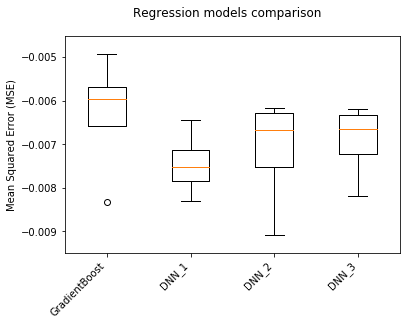

In [72]:
figure = plt.figure()
figure.suptitle('Feature Selection Scale Data Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(model_results)
axis.set_xticklabels(model_names, rotation = 45, ha="right")
axis.set_ylabel("Mean Squared Error (MSE)")
plt.margins(0.05, 0.1)
plt.show()

In [75]:
model_results = []
model_names   = []
for model_name in model_dict:
    model   = model_dict[model_name]
    k_fold  = KFold(n_splits=folds, random_state=1)
    results = cross_val_score(model, X_train_selection_feature_ts.drop(columns=['key']), Y_train_selection_feature_ts.drop(columns=['key']), cv=k_fold, scoring=metric)

    model_results.append(results)
    model_names.append(model_name)
    print("{}: {}".format(model_name, round(results.mean(), 5)))

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_

GradientBoost: -0.00676


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_1: -0.00678


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_2: -0.00662


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0

DNN_3: -0.00613


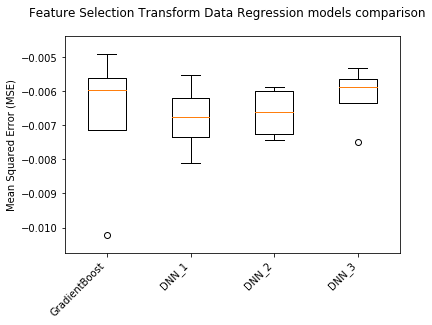

In [76]:
figure = plt.figure()
figure.suptitle('Feature Selection Transform Data Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(model_results)
axis.set_xticklabels(model_names, rotation = 45, ha="right")
axis.set_ylabel("Mean Squared Error (MSE)")
plt.margins(0.05, 0.1)
plt.show()

### Feature Selection 결과
* 기존 모든 Feature 13개를 Input으로 학습 했을 때보다 Feature Selection한 결과가 더 좋음을 확인.
* 8개의 Feature를 이용하여 모델을 튜닝하기로 결정.

### Feature Transform 결과
* feature를 정규분포와 유사하게 분포를 변경한 결과가 변경 전 보다 더 좋은 결과를 얻음. ( DNN 한정 )
* feature transform 한 데이터를 이용하여 모델을 튜닝하기로 결정.

### 3.4 모델 튜닝 
* 목적 : Gradient Boost Model과 Deep Neural Network Model의 성능을 간략하게 튜닝하여 최종적으로 Deep Dive할 모델을 선정하기 위한 목적
* 학습 데이터 전체를 학습하여 두 모델간의 예측 값에 따른 결과 비교 (빠른 결과 확인 목적)

### 3.4.1 Gradient Boost Model Tuning

In [77]:
params = {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 3, 
          'learning_rate': 0.001, 'loss': 'ls'}
best_model = GradientBoostingRegressor(**params)
best_model.fit(X_train_selection_feature_ts.drop(columns=['key']), Y_train_selection_feature_ts.drop(columns=['key']))

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss='ls', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=3,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

[INFO] MSE : 0.030524


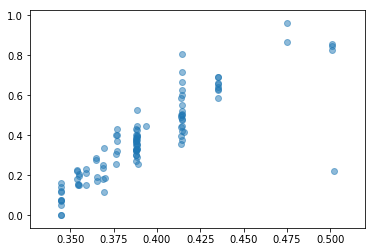

In [79]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

In [80]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 
          'learning_rate': 0.01, 'loss': 'ls'}
best_model = GradientBoostingRegressor(**params)
best_model.fit(X_train_selection_feature_ts.drop(columns=['key']), Y_train_selection_feature_ts.drop(columns=['key']))

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

[INFO] MSE : 0.005093


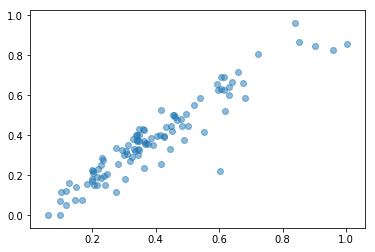

In [81]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

In [82]:
params = {'n_estimators': 700, 'max_depth': 4, 'min_samples_split': 2, 
          'learning_rate': 0.05, 'loss': 'ls'}
best_model = GradientBoostingRegressor(**params)
best_model.fit(X_train_selection_feature_ts.drop(columns=['key']), Y_train_selection_feature_ts.drop(columns=['key']))

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=700, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

[INFO] MSE : 0.005008


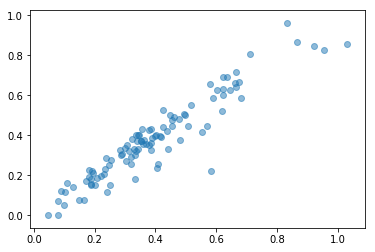

In [83]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

In [87]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 4, 
          'learning_rate': 0.005, 'loss': 'ls'}
best_model = GradientBoostingRegressor(**params)
best_model.fit(X_train_selection_feature_ts.drop(columns=['key']), Y_train_selection_feature_ts.drop(columns=['key']))

/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=4,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

[INFO] MSE : 0.005002


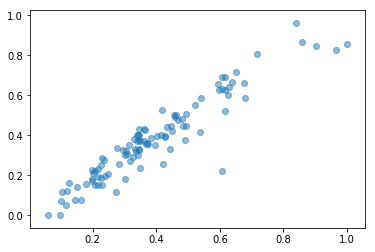

In [88]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 3.4.2 Deep Neural Network Model Tuning

In [89]:
def dnn_model_6(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_dim = 8))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [90]:
def dnn_model_7(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_dim = 8))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.005)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [91]:
def dnn_model_8(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_dim = 8))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [92]:
def dnn_model_9(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),input_dim = 8))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [256]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [93]:
best_model = dnn_model_6()
history=best_model.fit( X_train_selection_feature_ts.drop(columns=['key']),  
               Y_train_selection_feature_ts.drop(columns=['key']),
               epochs=400,
               validation_split = 0.2,
               batch_size=16, 
               verbose=0)

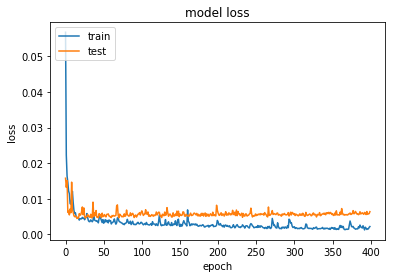

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.0053


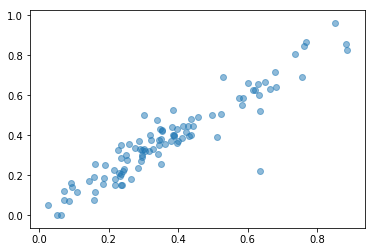

In [96]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* train loss와 test loss의 간극으로 보아 train set에 과적합된 결과를 보임
* 과적합을 해결하기 위한 대안이 필요

In [97]:
best_model = dnn_model_7()
history=best_model.fit( X_train_selection_feature_ts.drop(columns=['key']),  
               Y_train_selection_feature_ts.drop(columns=['key']),
               epochs=400,
               validation_split = 0.2,
               batch_size=16, 
               verbose=0)

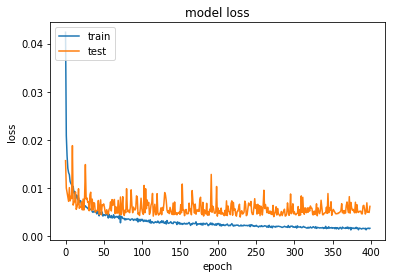

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.008036


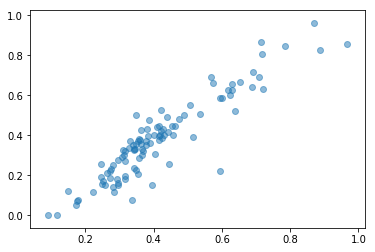

In [99]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* optimizer 변화에 따른 결과를 보면 과적합 문제는 그대로 유지되고 있으며 대략 50 ephoc 부터 과적합이 시작됨을 확인함.
* mse값이 더 커지는 것으로 보아 해당 Data는 adam optimizer가 더 적합하다고 판단.

In [100]:
best_model = dnn_model_8()
history=best_model.fit( X_train_selection_feature_ts.drop(columns=['key']),  
               Y_train_selection_feature_ts.drop(columns=['key']),
               epochs=400,
               validation_split = 0.2,
               batch_size=16, 
               verbose=0)

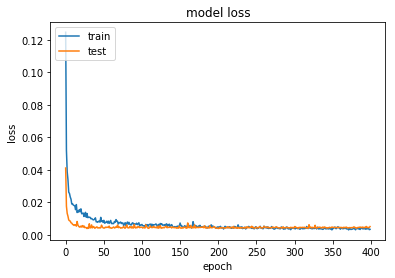

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.005835


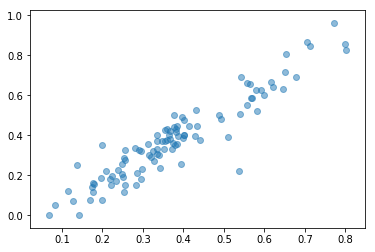

In [102]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* Drop out을 이용해 네트워크의 표현력 증가에 따라 과적합 이슈가 해도됨을 확인.

In [106]:
best_model = dnn_model_9()
history=best_model.fit( X_train_selection_feature_ts.drop(columns=['key']),  
               Y_train_selection_feature_ts.drop(columns=['key']),
               epochs=400,
               validation_split = 0.2,
               batch_size=16, 
               verbose=0)

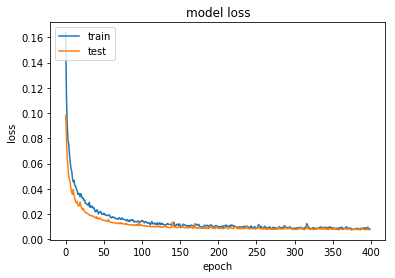

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.00481


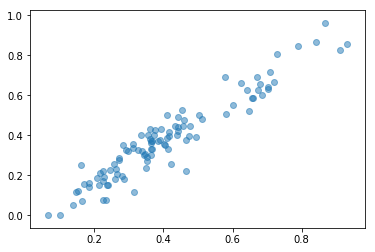

In [108]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* regulization을 통해 이전 모델보다 과적합 이슈가 개선됨을 확인함.

In [114]:
best_model = dnn_model_9()
history=best_model.fit( X_train_selection_feature_ts.drop(columns=['key']),  
               Y_train_selection_feature_ts.drop(columns=['key']),
               epochs=1000,
               validation_split = 0.2,
               batch_size=32, 
               verbose=0)

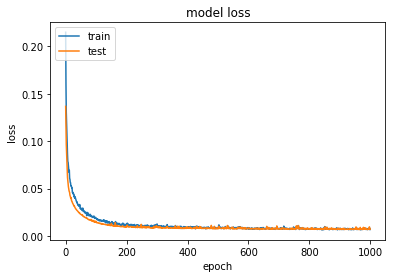

In [115]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

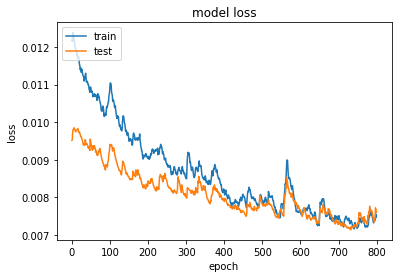

In [116]:
plt.plot( smooth_curve(history.history['loss'][200:]))
plt.plot(smooth_curve(history.history['val_loss'][200:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.004732


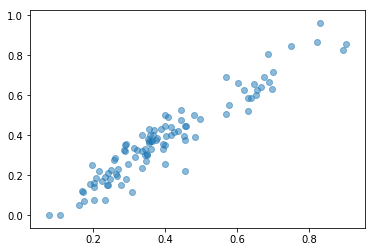

In [117]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* 학습시간을 늘려 train 한 결과 최적의 epoch은 약 900정도로 파악됨 

ValueError: Input passed into argument "'y1'"is not 1-dimensional.

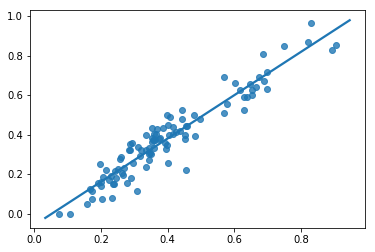

In [120]:
ax = sns.regplot(x=predictions, y=Y_test_selection_feature_ts.drop(columns=['key']).values)

### Deep Learning Model vs Gradient Boost Model 간략한 튜닝 결과
* 동일 Feature, 동일 Train, Test set을 이용하여 최종 모델 선정 목적으로 튜닝을 수행함.
* 전반적으로 Deep Learning 모델의 결과가 튜닝에 따라 결과가 개선되는 것으로 확인 됨.
* Gradient Boost 모델의 경우 한계점이 보임 (이에 대한 근거 보강 필요) 
* Deep Learning 모델의 경우 optimizer 변경에 따라 개선된 성능을 보임 - adam이 rmsprop 보다 더 좋은 결과를 냄
* Deep Learning 모델의 경우 drop out 추가에 따라 네트워크 표현력이 증가하여 개선된 성능을 보임
* Deep Learning 모델의 경우 regularization 추가에 따라 과적합 문제를 해결하는 것으로 보임
* Deep Learning 모델의 경우 최적 epoch은 약 600정도로 보임
* 최종 mse - 0.004732
* Deep Learning 모델의 성능을 끌어 올리기 위해 조금 더 Deep dive해서 보기로 결정

## 4. 최종 모델 Deep Dive
* 목적 : 최종적으로 선택된 DNN 모델을 튜닝하여 개선된 결과를 얻기 위함.

### 4.1 Hidden Layer 증가에 따른 모델튜닝
### 4.1.1 Hidden Layer 5개
* 목적 : Network Layer를 두껍게 쌓아 표현력을 강화하기 위함 

In [249]:
def k_fold_manual(X,Y, model, k=4, epoch=600, mini_batch_size = 16):
    train_data = X
    train_targets = Y
    
    num_val_samples = len(train_data) // k
    num_epochs = epoch
    history_list = []
    
    for i in range(k):
        print('처리중인 폴드 #', i)

        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0)

        deep_dive_model = model

        history=deep_dive_model.fit(partial_train_data, partial_train_targets, validation_split = 0.2,
                  epochs=num_epochs, batch_size=mini_batch_size, verbose=0)

        history_list.append(history)
    
    return history_list, deep_dive_model


In [250]:
def mean_k_fold_train_loss(history_list, k = 4):
    train_loss_mean=[]
    for i in range(0,len(history_list[0].history['loss'])):
        sum = 0.0
        for j in range ( 0, k ):
            sum+=history_list[j].history['loss'][i]
    
        train_loss_mean.append(sum / k)
    
    return train_loss_mean

In [251]:
def mean_k_fold_val_loss(history_list, k = 4):
    val_loss_mean=[]
    for i in range(0,len(history_list[0].history['val_loss'])):
        sum = 0.0
        for j in range ( 0, k ):
            sum+=history_list[j].history['val_loss'][i]
    
        val_loss_mean.append(sum / k)
    
    return val_loss_mean

In [155]:
def dnn_model_10(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_dim = 8))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [156]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                           Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                           model= dnn_model_10(), 
                           k=4, 
                           epoch=600, 
                           mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [157]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

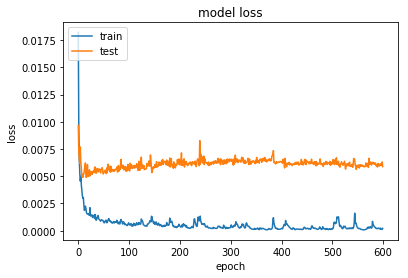

In [158]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.004887


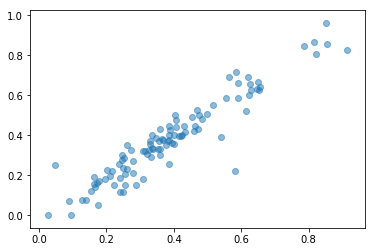

In [160]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* 과적합 이슈가 존재함.

### 4.1.2 Drop Out 추가
* 목적 : 이전 단계의 모델의 과적합 이슈를 해결하기 위함

In [164]:
def dnn_model_11(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_dim = 8))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [165]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_11(), 
                                   k=4, 
                                   epoch=600, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [166]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

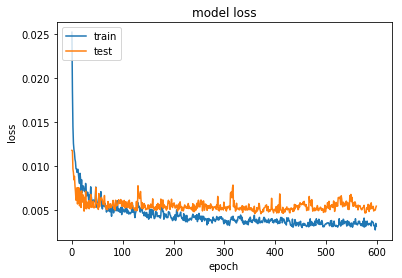

In [167]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.010854


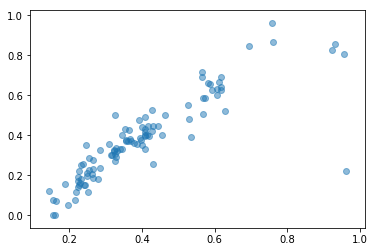

In [168]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* 네트워크 과적합 이슈를 감소시킴
* 하지만 여전히 과적합 이슈는 존재함.
* MSE가 더 커지는 문제 발생.(다음 interation을 통하여 early stop 지점을 찾아야 함)
* Drop Out Layer가 너무 많아 표현력을 오히려 잃는 것이 아니라는 판단이 듬.

### 4.1.3 Regularization 추가
* 목적 : 네트워크 과적합 이슈 감소 목적

In [175]:
def dnn_model_12(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),input_dim = 8))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.1))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [176]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_12(), 
                                   k=4, 
                                   epoch=600, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [177]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

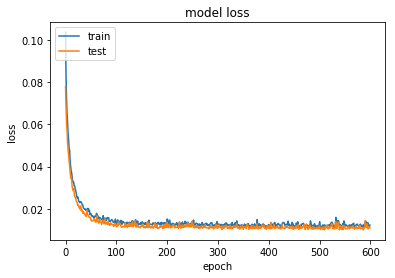

In [178]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

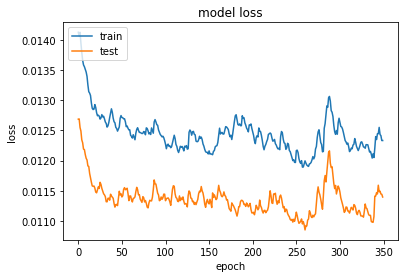

In [181]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.006948


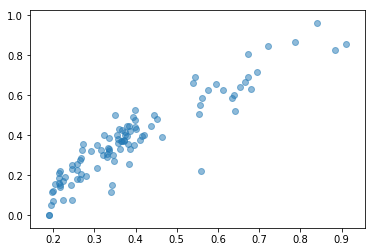

In [182]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* drop out 비율과 regularizers를 이용해 네트워크의 과적합은 줄일 수 있었음. 일반화가 잘 되었다라는 판단이 됨.
* MSE는 더 증가함.
* epoch을 늘리게 되면 조금더 fitting된 결과를 얻을 수 있지 않을까 판단 됨. 

### 4.1.4 학습시간 늘리기
* 목적 : 좀 더 Fitting된 결과를 얻기 위함.

In [183]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_12(), 
                                   k=4, 
                                   epoch=1500, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [184]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

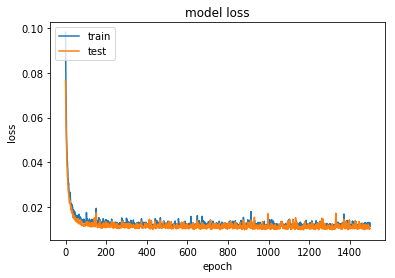

In [185]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

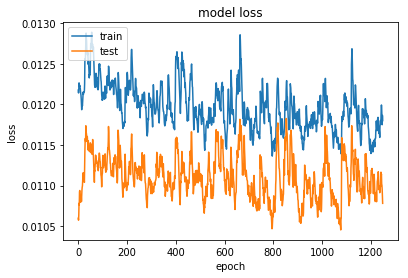

In [186]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.006442


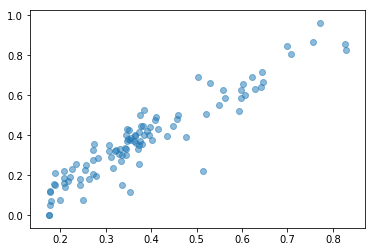

In [187]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 상위 모델 분석결과
* epoch을 길게하여 학습하여 테스트 셋의 MSE가 좀 더 감소함
* 튜닝 목적 network optimize 행위가 필요하다 판단.

### 4.1.5 Weight 초기화 변경
* 목적 : 네트워크 최적화 목적

In [189]:
def dnn_model_13(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [190]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_13(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [191]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

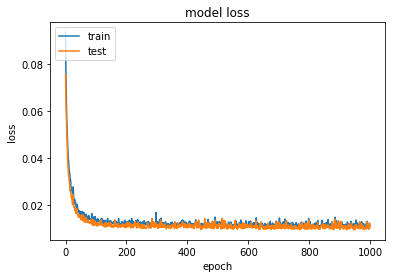

In [192]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

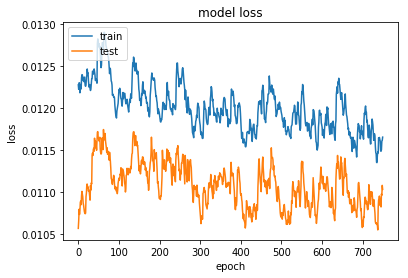

In [193]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.006014


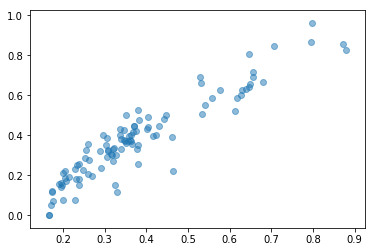

In [194]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 분석 결과
* xavier initialize를 추가하여 MSE가 감소함을 확인
* 추가적인 network optimize 행위가 필요하다 판단

### 4.1.6 Batch Normalization 추가
* 목적 : 네트워크 최적화

In [198]:
def dnn_model_14(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [199]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_14(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [200]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

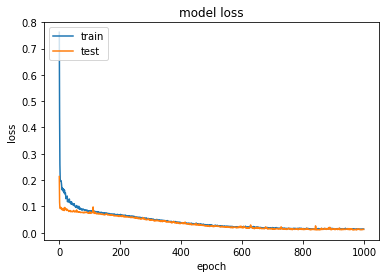

In [201]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

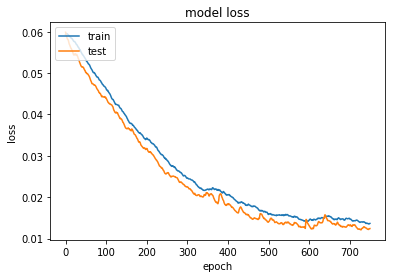

In [202]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.01294


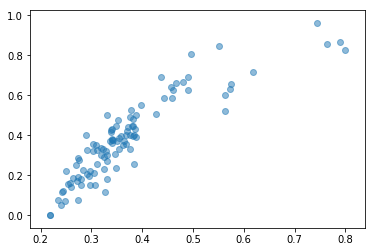

In [203]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

In [209]:
def dnn_model_14_1(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64,kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(layers.Dense(64,kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(layers.Dense(64,kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(layers.Dense(64,kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(layers.Dense(64,kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.01)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [210]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_14_1(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [211]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

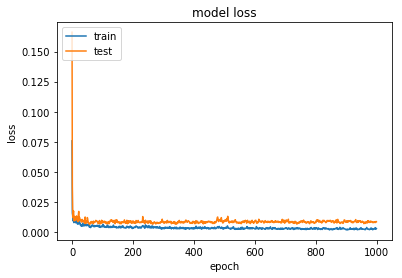

In [212]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

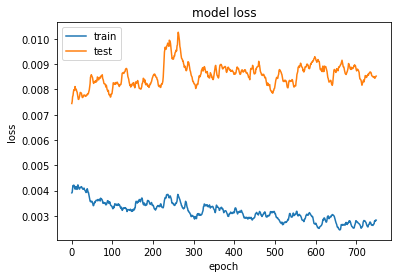

In [213]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.008249


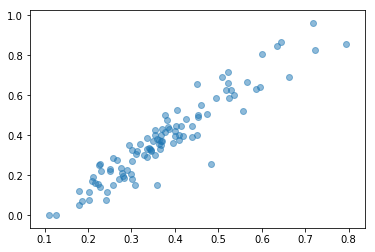

In [214]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

In [215]:
def dnn_model_14_2(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64,kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(layers.Dense(64,kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(layers.Dense(64,kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(layers.Dense(64,kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(layers.Dense(64,kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [216]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_14_2(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [217]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

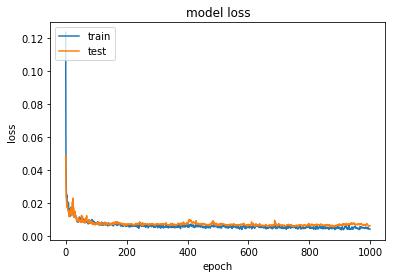

In [218]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

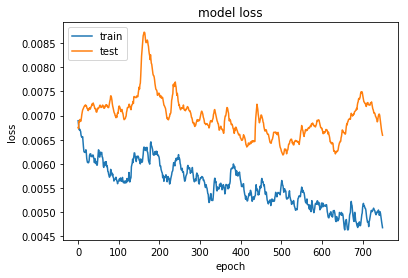

In [219]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.006801


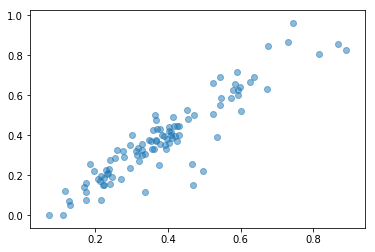

In [220]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* Batch Normalization 추가 시 오히려 성능이 많이 저하됨. 
* Drop Out, Regulization을 뺴고 Batch Normalization 추가, learning rate 증가 하여도 성능은 향상되지 않음.
* input 자체가 Normalizaton 된 데이터이기 때문에 이미 Batch Normlization의 효과를 반영하고 있는 것이 아닌가라는 판다이 듦.

### 4.1.7 Learning Rate 변경

In [221]:
def dnn_model_15(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [222]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_15(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [224]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

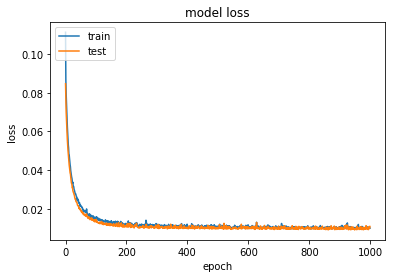

In [225]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

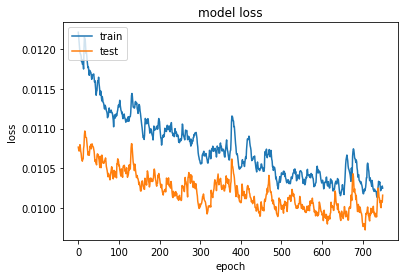

In [226]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.009538


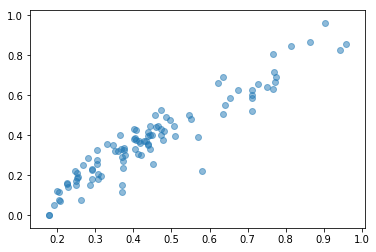

In [228]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

In [229]:
def dnn_model_15_1(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [230]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_15_1(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [232]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

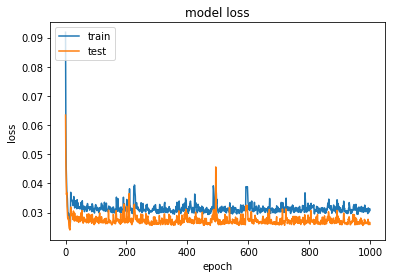

In [233]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

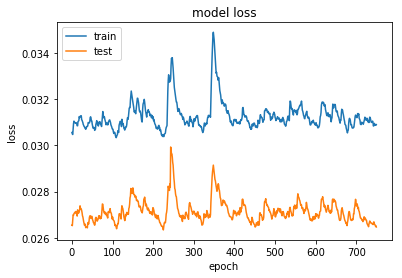

In [234]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.041665


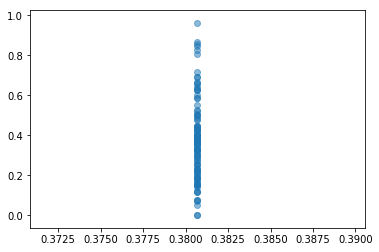

In [238]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* learning rate 증감에 따른 성능 향상은 없음을 확인.

### 4.1.8 Mini Batch Size 변경
* 목적 : Batch Size 변경에 따른 성능 개선 확인

In [236]:
def dnn_model_16(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [239]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_16(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [240]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

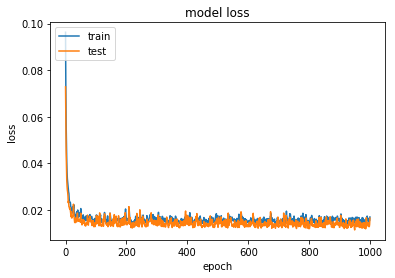

In [241]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

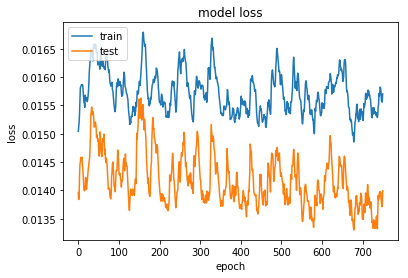

In [242]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.018463


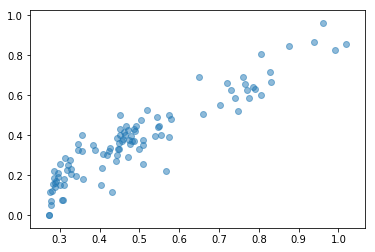

In [243]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 분석 결과
* mini batch 사이즈를 늘릴 경우 성능 저하가 발생.

### 4.1.9 학습시간 늘리기

In [249]:
def dnn_model_17(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [250]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_17(), 
                                   k=4, 
                                   epoch=2000, 
                                   mini_batch_size = 16)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [251]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

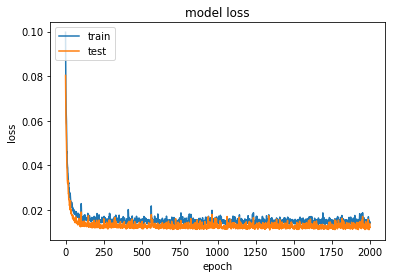

In [252]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

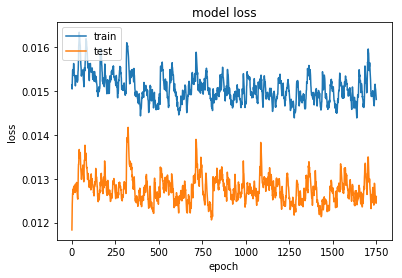

In [253]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.009861


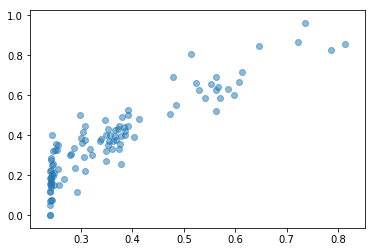

In [254]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 분석 결과
* MSE가 오히려 증가함

### 최종 결론
* 5 hidden layer 모델에서 가장 성능이 높은 환경은 아래와 같음
* epoch 1000 , mini batch size 16, learning rate 0.001 
* regularizers, drop out, xavier init
* 하지만 히든 레이어를 얇게 쌓은 모델(Chapter 3 내용)보다 성능이 더 좋지 못함을 확인.
* 해당 input 데이터는 오히려 2 hidden layer가 더 적합한 모델일 수도 있겠다는 판단.
* 최종 평가 데이터셋 mse - 0.006014

### 4.2 Chapter 3 - 2 Hidden Layer 모델 튜팅

In [255]:
def dnn_model_18(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),input_dim = 8))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [256]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_18(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [257]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

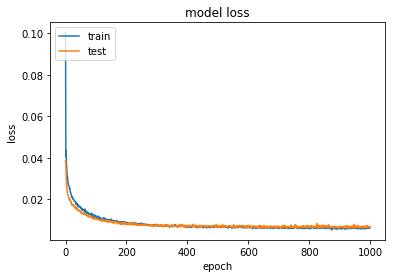

In [258]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

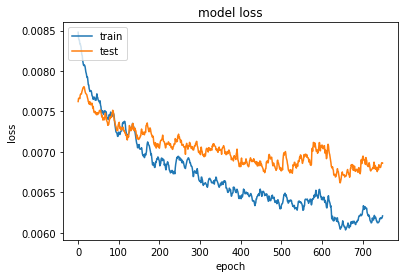

In [259]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.007419


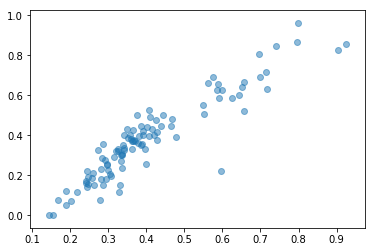

In [260]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 4.2.1 Weight 초기화 변경

In [261]:
def dnn_model_19(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [262]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_19(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [263]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

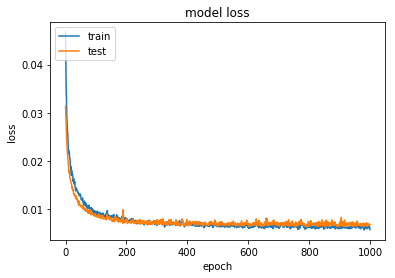

In [264]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

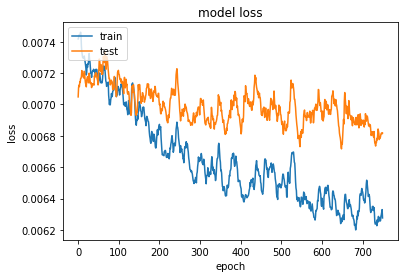

In [265]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.004676


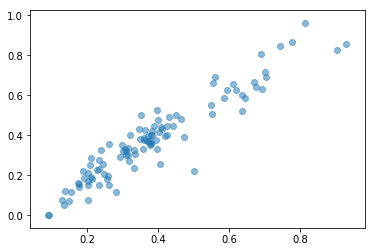

In [266]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* weight 초기화를 xavier로 바꾸고 난 후 성능이 개선됨.
* 과적합 이슈가 존재

### 4.2.3 Learning Rate 변경
* 목적 : 과적합 개선 목적

In [268]:
def dnn_model_20(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.003)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [269]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_20(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


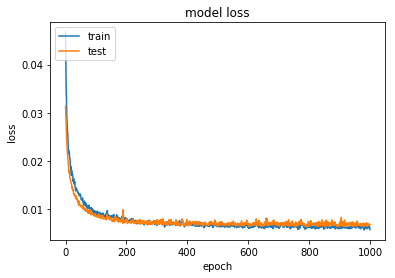

In [270]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

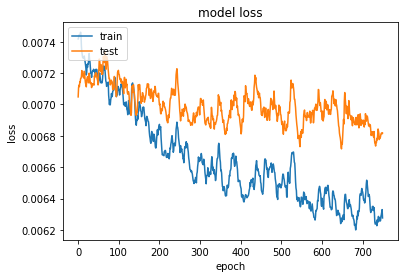

In [271]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.006592


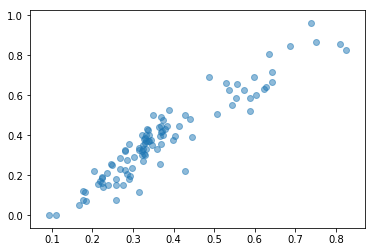

In [272]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* 과적합 이슈 존재
* learning rate는 기존 설정이 더 좋은 설정으로 판단됨.

### 4.2.2 Drop Out 변경
* 목적 : 과적합 개선 목적

In [279]:
def dnn_model_21(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 8))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.1))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [280]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_21(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [281]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

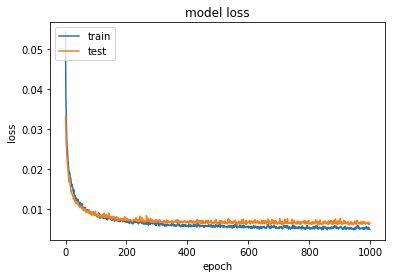

In [282]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

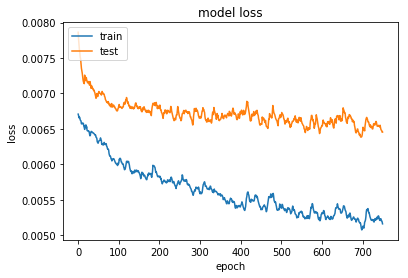

In [283]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.004886


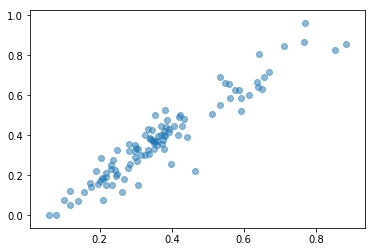

In [284]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 4.2.3 Early Stopping

In [290]:
history_list, model =k_fold_manual(X = X_train_selection_feature_ts.drop(columns=['key']),
                                   Y = Y_train_selection_feature_ts.drop(columns=['key']), 
                                   model= dnn_model_19(), 
                                   k=4, 
                                   epoch=500, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [291]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

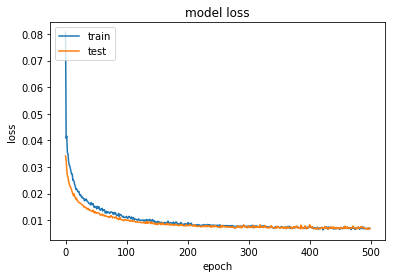

In [292]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

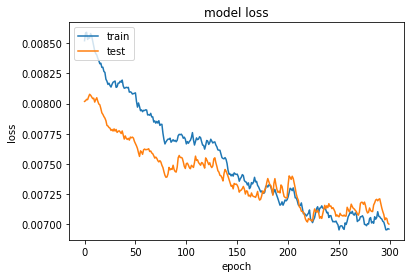

In [299]:
plt.plot( smooth_curve(train_loss_mean[200:]))
plt.plot(smooth_curve(val_loss_mean[200:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.004782


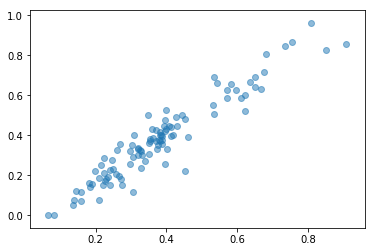

In [294]:
predictions = model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* Early Stopping 통하여 최적지점의 결과를 도출

In [295]:
best_model = dnn_model_19()
history=best_model.fit( X_train_selection_feature_ts.drop(columns=['key']),  
               Y_train_selection_feature_ts.drop(columns=['key']),
               epochs=500,
               validation_split = 0.2,
               batch_size=32, 
               verbose=0)

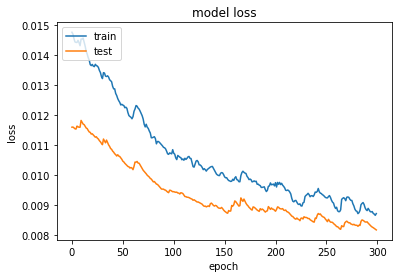

In [296]:
plt.plot( smooth_curve(history.history['loss'][200:]))
plt.plot(smooth_curve(history.history['val_loss'][200:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


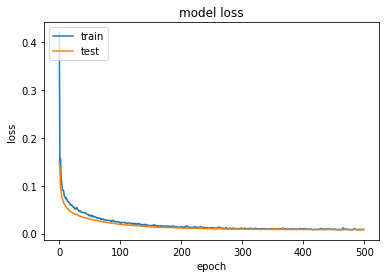

In [297]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.004276


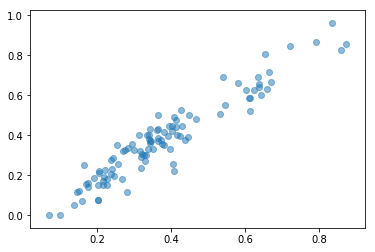

In [298]:
predictions = best_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

In [300]:
model_json=best_model.to_json()
with open("model.json","w") as json_file :
    json_file.write(model_json)

In [425]:
best_model.save_weights("model.h5")

### 최종 결론
* 2 hidden layer 모델에서 가장 성능이 높은 환경은 아래와 같음
* epoch 500 , mini batch size 32, learning rate 0.001
* regularizers, drop out, xavier init
* 최종 평가 데이터셋 mse - 0.004276

### 4.3 Feature 추가 및 변경에 따른 모델 튜닝
* 목적 : 기존에 사용하지 않았던 feature를 재 가공하여 의미 부여 후 학습
* 사용하지 않은 feature들을 그대로 사용하거나 카테고리 데이터 인코딩을 통하여 의미 부여 후 학습
* 모든 feature 13개를 가공 없이 사용했을 때와 카테고리 데이터로 변경 후의 결과를 비교

### 4.3.1 EDA

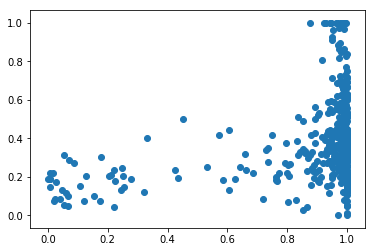

In [301]:
plt.scatter(x=scale_data['B'],y=scale_data['MEDV'])

In [302]:
scale_data['B'].describe()

count    506.000000
mean       0.898568
std        0.230205
min        0.000000
25%        0.945730
50%        0.986232
75%        0.998298
max        1.000000
Name: B, dtype: float64

### B 분석
* Percentile 25% 이상의 데이터가 대부분 0.94이상의 데이터로 분포하고 있음.
* B는 TAX,RAD,DIS와 연관 관계가 있음.
* 집값과의 관계는 뚜렷하지 않지만 0.9이하의 데이터는 양의 상관 관계를 가지는 것으로 보임.

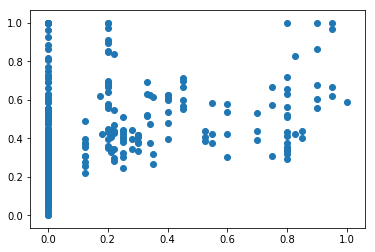

In [303]:
plt.scatter(x=scale_data['ZN'],y=scale_data['MEDV'])

In [304]:
scale_data['ZN'].describe()

count    506.000000
mean       0.113636
std        0.233225
min        0.000000
25%        0.000000
50%        0.000000
75%        0.125000
max        1.000000
Name: ZN, dtype: float64

### ZN 분석
* Percentile 75% 이하의 데이터가 대부분 0.0에 분포하고 있음.
* 0.0 이상인 데이터들은 많지 않지만 집값과 양의 상관 관계의 경향성을 보임.
* 해당 데이터는 DIS 데이터와 상관계수가 높음.
* DIS 데이터 함께 집값에 영향을 줄 수 있는 여지가 있어보임.

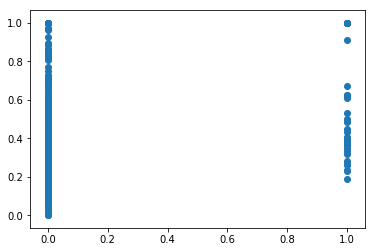

In [305]:
plt.scatter(x=scale_data['CHAS'],y=scale_data['MEDV'])

### CHAS 분석
* 대부분이 0으로 구성된 카테고리 데이터

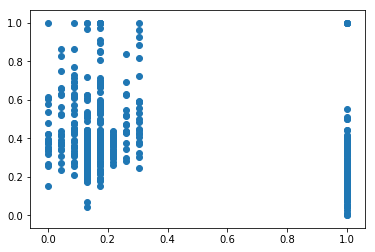

In [307]:
plt.scatter(x=scale_data['RAD'],y=scale_data['MEDV'])

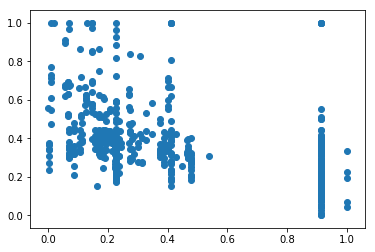

In [308]:
plt.scatter(x=scale_data['TAX'],y=scale_data['MEDV'])

### TAX & RAD 분석
* TAX와 RAD는 매우 높은 상관 관계를 가지고 있음.
* 해당 데이터를 Binary Encoding 하기로 결정

### 4.3.2 Feature  Engineering
* 목적 : TAX 와 RAD 데이터를 Binary Encoding

In [164]:
X_train_all_feature = X_train_scale[['RM','LSTAT','PTRATIO','CRIM','INDUS','NOX','AGE','DIS','B','ZN','CHAS','RAD','TAX','key']]
Y_train_all_feature = Y_train_scale[['MEDV','key']]
X_test_all_feature = X_test_scale[['RM','LSTAT','PTRATIO','CRIM','INDUS','NOX','AGE','DIS','B','ZN','CHAS','RAD','TAX','key']]
Y_test_all_feature = Y_test_scale[['MEDV','key']]

In [165]:
X_train_all_feature['TAX']= X_train_all_feature.TAX.apply(lambda x: 1 if x > 0.6 else 0 )

In [166]:
X_train_all_feature['RAD']= X_train_all_feature.TAX.apply(lambda x: 1 if x > 0.4 else 0 )

### 4.3.3 학습 
### 4.3.3.1 범주형 인코딩 Input 추가

In [313]:
def dnn_model_22(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 13))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [314]:
history_list, model =k_fold_manual(X = X_train_all_feature.drop(columns=['key']),
                                   Y = Y_train_all_feature.drop(columns=['key']), 
                                   model= dnn_model_22(), 
                                   k=4, 
                                   epoch=500, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [315]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

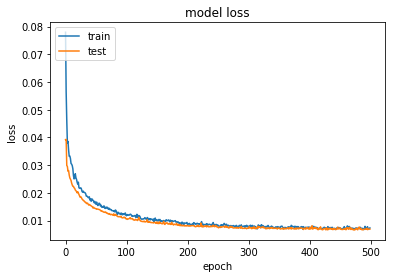

In [316]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

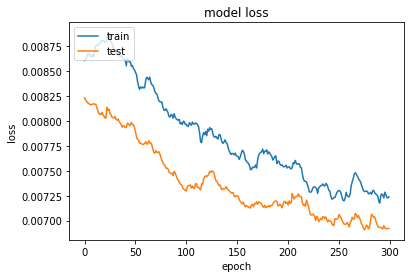

In [317]:
plt.plot( smooth_curve(train_loss_mean[200:]))
plt.plot(smooth_curve(val_loss_mean[200:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.005262


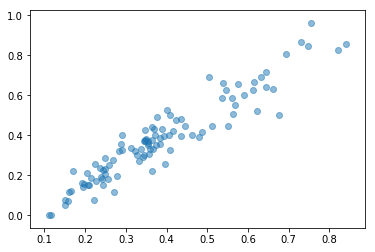

In [318]:
predictions = model.predict( X_test_all_feature.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_all_feature.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_all_feature.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* Feature Selection한 결과와 비교했을 때 나쁘지 않은 성능을 보임.
* 튜닝 시 발전 가능성 보임

### 4.3.3.2 원본 형태 Input

In [167]:
X_train_all_feature = X_train_scale[['RM','LSTAT','PTRATIO','CRIM','INDUS','NOX','AGE','DIS','B','ZN','CHAS','RAD','TAX','key']]
Y_train_all_feature = Y_train_scale[['MEDV','key']]
X_test_all_feature = X_test_scale[['RM','LSTAT','PTRATIO','CRIM','INDUS','NOX','AGE','DIS','B','ZN','CHAS','RAD','TAX','key']]
Y_test_all_feature = Y_test_scale[['MEDV','key']]

In [320]:
history_list, model =k_fold_manual(X = X_train_all_feature.drop(columns=['key']),
                                   Y = Y_train_all_feature.drop(columns=['key']), 
                                   model= dnn_model_22(), 
                                   k=4, 
                                   epoch=500, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


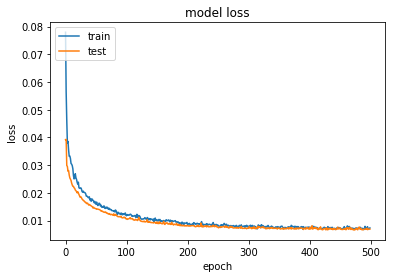

In [321]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

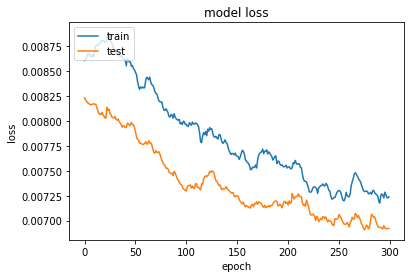

In [322]:
plt.plot( smooth_curve(train_loss_mean[200:]))
plt.plot(smooth_curve(val_loss_mean[200:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.004842


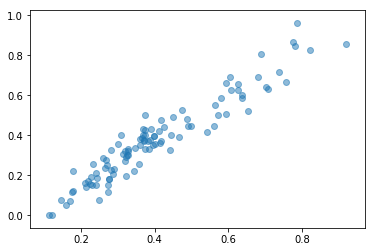

In [323]:
predictions = model.predict( X_test_all_feature.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_all_feature.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_all_feature.drop(columns=['key']), alpha=0.5)
plt.show()

### 결과 분석
* 최종적으로 Feature Selection한 결과보다 낮은 성능을 보임.
* 범주형 인코딩한 데이터보다 원본 그대로의 데이터를 넣었을 경우 더 좋은 표현력을 가지는 것으로 보임.

### 4.4 Attention Mechanism기반 Feature Importance 측정
* 목적 : 상위 Chapter 4.2에서 테스트한 모델에 대한 Feature가 정말로 잘 선택된 Feature인지 확인하기 위함.
* attention machanism을 이용해 활성화된 attention layer를 통해 feature의 중요도 분석

### 4.4.1 Feature Engineering
* 기존 Feature를 이용하여 활성화 Feature를 확인하기 위한 목적
* 기존 Feature에 노이즈 Feature를 추가 - 기존 Feature대비 활성화되는 Feature를 부각되게 하기 위한 목적

In [168]:
X_train_base_feature=X_train_all_feature.drop(columns=['key'])
Y_train_base_feature=Y_train_all_feature.drop(columns=['key'])
X_test_base_feature=X_test_all_feature.drop(columns=['key'])
Y_test_base_feature=Y_test_all_feature.drop(columns=['key'])

In [217]:
X_train_base_feature['dummy_1']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_2']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_3']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_4']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_5']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_6']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_7']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_8']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_9']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_10']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_11']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_12']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))
X_train_base_feature['dummy_13']= np.random.uniform(0,1, size=(X_train_base_feature.shape[0]))


In [199]:
X_test_base_feature['dummy_1']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_2']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_3']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_4']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_5']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_6']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_7']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_8']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_9']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_10']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_11']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_12']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))
X_test_base_feature['dummy_13']= np.random.uniform(0,1, size=(X_test_base_feature.shape[0]))


In [328]:
print(X_train_base_feature.shape)
print(X_test_base_feature.shape)

(404, 26)
(102, 26)


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


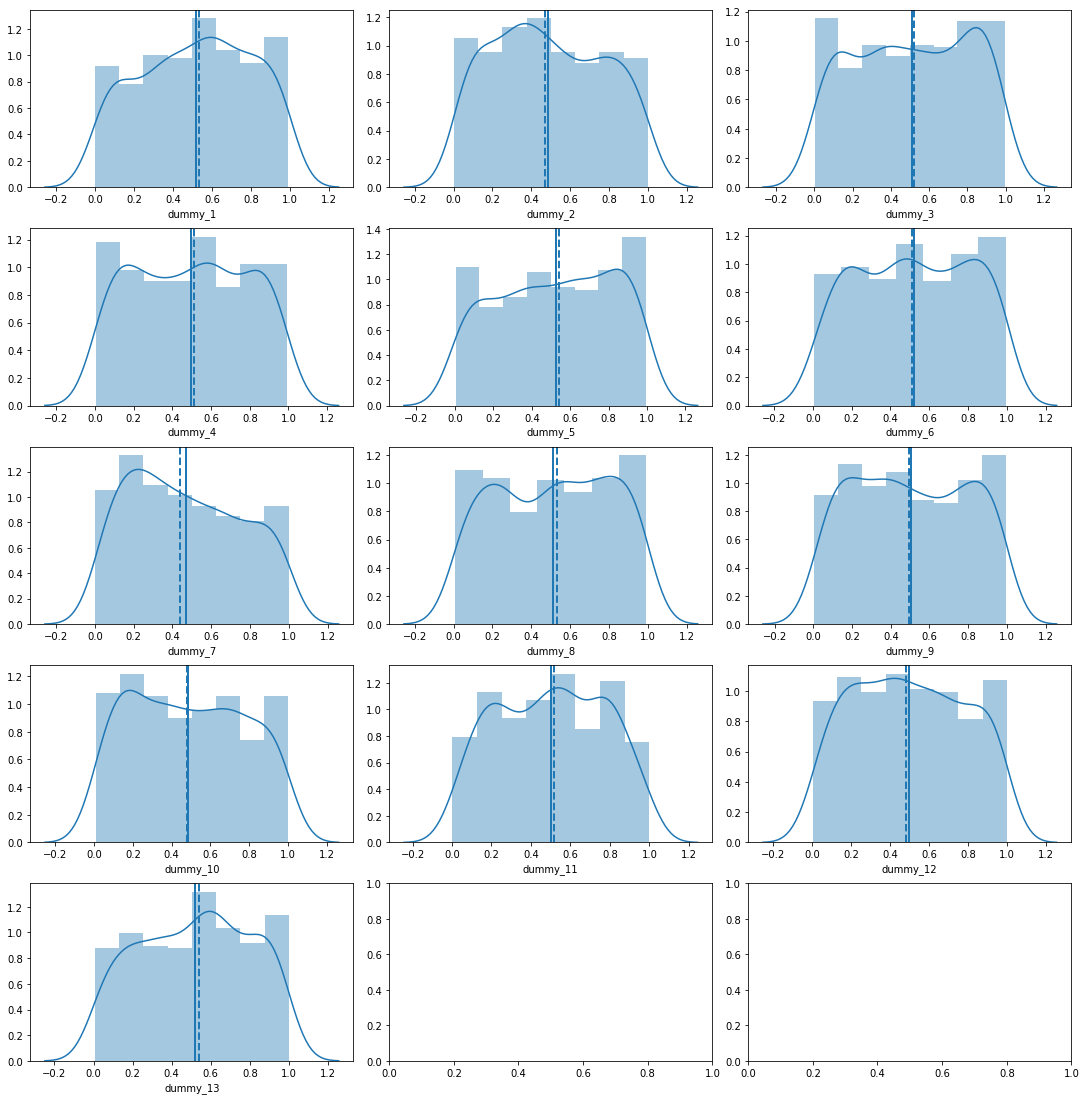

In [329]:
# input data feature 별 데이터의 분포

width = 3
height = 5

axes = plt.subplots(height,width,figsize=(15,15))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

for i in range(1,14):
        plt.subplot(height,width, i)
        sns.distplot(X_train_base_feature['dummy_'+str(i)])
        plt.axvline(X_train_base_feature['dummy_'+str(i)].mean(), linestyle='solid', linewidth=2)
        plt.axvline(X_train_base_feature['dummy_'+str(i)].median(), linestyle='dashed', linewidth=2)


### 4.4.2 Attention Layer 학습

In [396]:
train_shape = X_train_base_feature.shape[1]

input_layer = keras.Input(shape=(26,1), name='l_input')

x = layers.Flatten(name='l_flatten')(input_layer)

attention_probs = layers.Dense(26, activation='softmax', name='attention_vec')(x)
attention_mul = layers.Multiply(name='attention_mul')([x, attention_probs])

x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 26)(attention_mul)
x = Dropout(0.2)(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform")(x)
x = Dropout(0.2)(x)
x = layers.Dense(1)(x)

optimizer = Adam(lr=0.001)
  
md = Model(input_layer, x)
md.summary()
md.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
l_input (InputLayer)            (None, 26, 1)        0                                            
__________________________________________________________________________________________________
l_flatten (Flatten)             (None, 26)           0           l_input[0][0]                    
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 26)           702         l_flatten[0][0]                  
__________________________________________________________________________________________________
attention_mul (Multiply)        (None, 26)           0           l_flatten[0][0]                  
                                                                 attention_vec[0][0]              
__________

In [397]:
x_train = X_train_base_feature.values.reshape(X_train_base_feature.shape + (1,))

In [398]:
x_train.shape

(404, 26, 1)

In [399]:
history=md.fit( x= x_train,  
               y = Y_train_base_feature,
               epochs=500,
               shuffle=True,
               validation_split = 0.2,
               batch_size=16, 
               verbose=0)

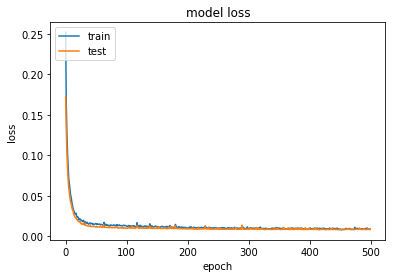

<Figure size 432x288 with 0 Axes>

In [400]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.clf()

[INFO] MSE : 0.006674


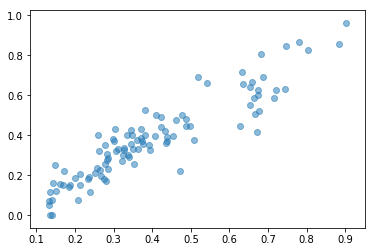

In [401]:
# make predictions using the model
x_test = X_test_base_feature.values.reshape(X_test_base_feature.shape + (1,))

predictions = md.predict( x_test)

predictions.shape
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_base_feature, predictions), 6)))
plt.scatter(predictions, Y_test_base_feature, alpha=0.5)
plt.show()

### 4.4.3 활성화 층 확인

In [32]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [576]:
rand_index = np.random.randint(0,102, size=1)[0]
test_data = X_test_base_feature.values[rand_index].reshape((1,)+ X_test_base_feature.values[rand_index].shape + (1,))

print(test_data.shape)

attention_vector = get_activations(md, test_data, print_shape_only=True, layer_name='attention_vec')[0].flatten()
print('attention =', attention_vector)
print(attention_vector.shape)


(1, 26, 1)
----- activations -----
(1, 26)
attention = [1.1884587e-01 3.5437614e-01 2.7231447e-04 2.1650736e-05 3.4542922e-05
 8.4677915e-05 2.1563491e-04 5.0292742e-01 9.6053998e-05 1.2757251e-04
 2.1907413e-02 2.9992867e-05 9.0672169e-05 1.4924832e-05 1.2975009e-05
 2.6471971e-04 4.6004261e-05 2.9286239e-05 8.4237327e-05 1.1346809e-05
 7.6438424e-05 3.2738939e-05 2.0858633e-05 3.3520511e-04 3.1608255e-05
 9.7155907e-06]
(26,)


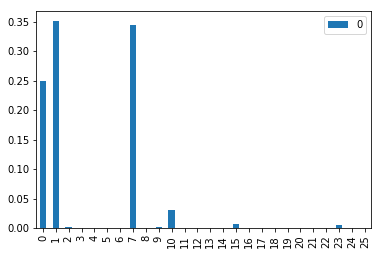

<Figure size 432x288 with 0 Axes>

In [202]:
import matplotlib.pyplot as plt
import pandas as pd

df_attention = pd.DataFrame(attention_vector)

df_attention.plot(kind='bar')
plt.show()
plt.clf()

In [363]:
X_train_all_feature.head()

,RM,LSTAT,PTRATIO,CRIM,INDUS,NOX,AGE,DIS,B,ZN,CHAS,RAD,TAX,key
0,0.354666,0.767660,0.638298,0.003183,0.371334,0.213992,0.071061,0.223508,0.879041,0.00,0,0.130435,0.171756,214
1,0.613336,0.214404,0.755319,0.001351,0.171188,0.139918,0.417096,0.623021,0.996672,0.25,0,0.304348,0.185115,63
2,0.589002,0.117550,0.468085,0.000098,0.056818,0.102881,0.276004,0.656039,0.984972,0.80,0,0.130435,0.177481,348
3,0.698410,0.175773,0.042553,0.006112,0.128666,0.539095,0.913491,0.072793,0.977281,0.20,0,0.173913,0.146947,264
4,0.818164,0.075055,0.553191,0.000559,0.073314,0.211934,0.522142,0.188198,0.989233,0.00,0,0.086957,0.011450,186


### 4.4.4 Attention Layer 학습 

In [219]:
X_train_base_feature_origin=X_train_all_feature.drop(columns=['key'])
Y_train_base_feature_origin=Y_train_all_feature.drop(columns=['key'])
X_test_base_feature_origin=X_test_all_feature.drop(columns=['key'])
Y_test_base_feature_origin=Y_test_all_feature.drop(columns=['key'])

In [220]:
print(X_train_base_feature_origin.shape)
print(X_test_base_feature_origin.shape)

(404, 13)
(102, 13)


In [221]:
train_shape = X_train_base_feature_origin.shape[1]

input_layer = keras.Input(shape=(13,1), name='l_input')

x = layers.Flatten(name='l_flatten')(input_layer)

attention_probs = layers.Dense(13, activation='softmax', name='attention_vec')(x)
attention_mul = layers.Multiply(name='attention_mul')([x, attention_probs])

x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 26)(attention_mul)
x = Dropout(0.2)(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform")(x)
x = Dropout(0.2)(x)
x = layers.Dense(1)(x)

optimizer = Adam(lr=0.001)
  
md = Model(input_layer, x)
md.summary()
md.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
l_input (InputLayer)            (None, 13, 1)        0                                            
__________________________________________________________________________________________________
l_flatten (Flatten)             (None, 13)           0           l_input[0][0]                    
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 13)           182         l_flatten[0][0]                  
__________________________________________________________________________________________________
attention_mul (Multiply)        (None, 13)           0           l_flatten[0][0]                  
                                                                 attention_vec[0][0]              
__________

In [222]:
x_train = X_train_base_feature_origin.values.reshape(X_train_base_feature_origin.shape + (1,))

In [223]:
history=md.fit( x= x_train,  
               y = Y_train_base_feature_origin,
               epochs=500,
               shuffle=True,
               validation_split = 0.2,
               batch_size=16, 
               verbose=0)

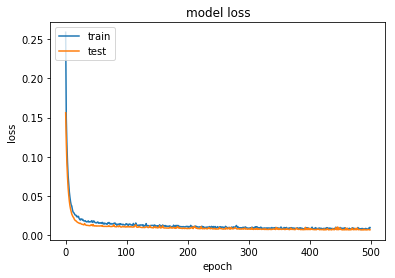

<Figure size 432x288 with 0 Axes>

In [224]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.clf()

[INFO] MSE : 0.00502


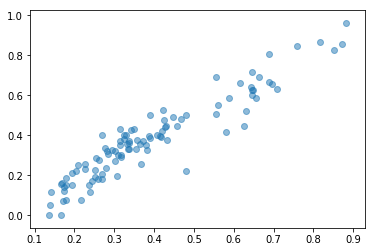

In [225]:
x_test = X_test_base_feature_origin.values.reshape(X_test_base_feature_origin.shape + (1,))

predictions = md.predict( x_test)

predictions.shape
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_base_feature_origin, predictions), 6)))
plt.scatter(predictions, Y_test_base_feature_origin, alpha=0.5)
plt.show()

### 4.4.5 활성화 층 확인

In [242]:
rand_index = np.random.randint(0,102, size=1)[0]
test_data = X_test_base_feature_origin.values[rand_index].reshape((1,)+ X_test_base_feature_origin.values[rand_index].shape + (1,))

print(test_data.shape)

attention_vector = get_activations(md, test_data, print_shape_only=True, layer_name='attention_vec')[0].flatten()
print('attention =', attention_vector)
print(attention_vector.shape)

(1, 13, 1)
----- activations -----
(1, 13)
attention = [7.6139383e-02 5.7541978e-01 2.3064802e-03 2.3751126e-03 3.7768702e-03
 1.0898593e-02 6.4120977e-04 1.3559059e-02 2.9142275e-01 1.9314444e-03
 2.0314241e-02 6.6184916e-04 5.5322616e-04]
(13,)


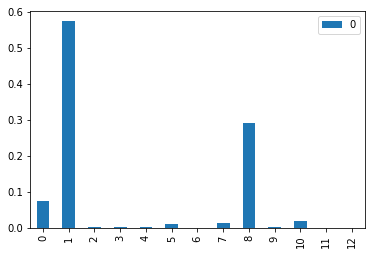

<Figure size 432x288 with 0 Axes>

In [243]:
import matplotlib.pyplot as plt
import pandas as pd

df_attention = pd.DataFrame(attention_vector)

df_attention.plot(kind='bar')
plt.show()
plt.clf()

In [244]:
X_train_all_feature.head()

,RM,LSTAT,PTRATIO,CRIM,INDUS,NOX,AGE,DIS,B,ZN,CHAS,RAD,TAX,key
0,0.354666,0.767660,0.638298,0.003183,0.371334,0.213992,0.071061,0.223508,0.879041,0.00,0,0.130435,0.171756,214
1,0.613336,0.214404,0.755319,0.001351,0.171188,0.139918,0.417096,0.623021,0.996672,0.25,0,0.304348,0.185115,63
2,0.589002,0.117550,0.468085,0.000098,0.056818,0.102881,0.276004,0.656039,0.984972,0.80,0,0.130435,0.177481,348
3,0.698410,0.175773,0.042553,0.006112,0.128666,0.539095,0.913491,0.072793,0.977281,0.20,0,0.173913,0.146947,264
4,0.818164,0.075055,0.553191,0.000559,0.073314,0.211934,0.522142,0.188198,0.989233,0.00,0,0.086957,0.011450,186


### 활성화 층 분석 결과
* Test Set의 Attention layer 대부분이 RM,LSTAT,NOX,DIS,B,CHAS에 집중되어 있는걸 볼 수 있음.

### 4.4.6 Feature Selection 
* Attention layer의 활성화층을 기반으로 Feature를 재선정

In [246]:
X_train_new_selection_feature = X_train_all_feature[['RM','LSTAT','NOX','DIS','B','CHAS','key']]
Y_train_new_selection_feature = Y_train_all_feature[['MEDV','key']]
X_test_new_selection_feature = X_test_all_feature[['RM','LSTAT','NOX','DIS','B','CHAS','key']]
Y_test_new_selection_feature = Y_test_all_feature[['MEDV','key']]

In [247]:
print(X_train_new_selection_feature.shape)
print(X_test_new_selection_feature.shape)

(404, 7)
(102, 7)


### 4.4.7 모델 학습

In [265]:
def dnn_model_23(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform",input_dim = 6))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [266]:
history_list, model =k_fold_manual(X = X_train_new_selection_feature.drop(columns=['key']),
                                   Y = Y_train_new_selection_feature.drop(columns=['key']), 
                                   model= dnn_model_23(), 
                                   k=4, 
                                   epoch=1000, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [267]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

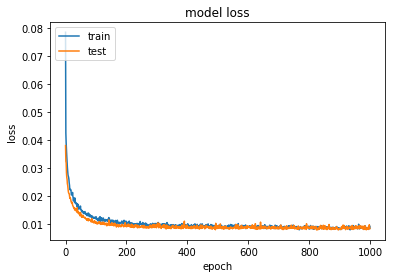

In [268]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

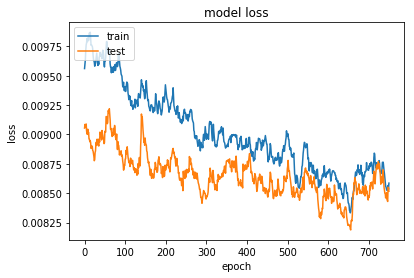

In [269]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.008832


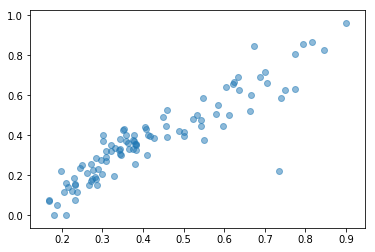

In [271]:
predictions = model.predict( X_test_new_selection_feature.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_new_selection_feature.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_new_selection_feature.drop(columns=['key']), alpha=0.5)
plt.show()

In [272]:
def dnn_model_24(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),input_dim = 6))
    model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [278]:
history_list, model =k_fold_manual(X = X_train_new_selection_feature.drop(columns=['key']),
                                   Y = Y_train_new_selection_feature.drop(columns=['key']), 
                                   model= dnn_model_24(), 
                                   k=4, 
                                   epoch=500, 
                                   mini_batch_size = 32)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [279]:
train_loss_mean = mean_k_fold_train_loss(history_list)
val_loss_mean = mean_k_fold_val_loss(history_list)

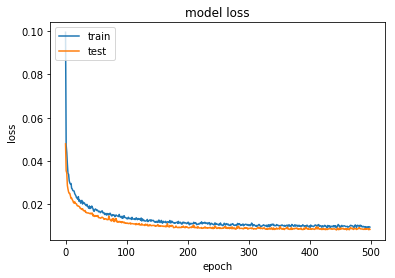

In [280]:
plt.plot(train_loss_mean)
plt.plot(val_loss_mean)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

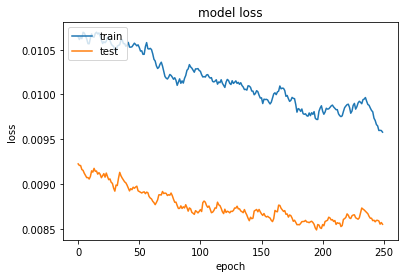

In [281]:
plt.plot( smooth_curve(train_loss_mean[250:]))
plt.plot(smooth_curve(val_loss_mean[250:]))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[INFO] MSE : 0.00611


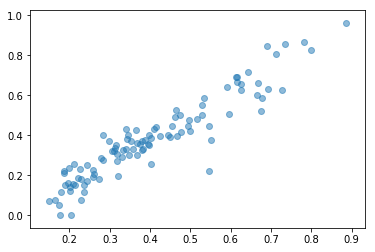

In [282]:
predictions = model.predict( X_test_new_selection_feature.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_new_selection_feature.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_new_selection_feature.drop(columns=['key']), alpha=0.5)
plt.show()

### 분석 결과
* 새로 선택한 Feature로 학습 시 기 최종 선택한 모델보다는 좋은 성능을 보이지 못함.
* 새로 선택한 Feature가 기존 모델에서 선택한 Feature 대부분에 포함되고 포함되지 않은 Feature와 결합되어 유의미한 결과를 내는 것이 아닌가 판단됨.

------------------------------------------------------------

## 5. 결론

### 5.1 최종 모델

In [536]:
json_file = open("model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [537]:
loaded_model.load_weights("model.h5")

In [538]:
loaded_model.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])

[INFO] MSE : 0.004276


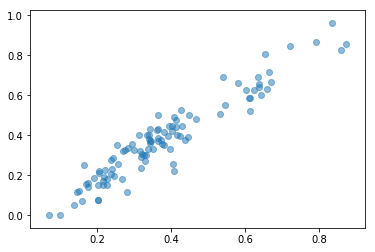

In [539]:
predictions = loaded_model.predict( X_test_selection_feature_ts.drop(columns=['key']))
print("[INFO] MSE : {}".format(round(mean_squared_error( Y_test_selection_feature_ts.drop(columns=['key']), predictions), 6)))

plt.scatter(predictions, Y_test_selection_feature_ts.drop(columns=['key']), alpha=0.5)
plt.show()

### 5.2 평가 및 측정

In [180]:
df_prdiction = pd.DataFrame(predictions,columns=['pred_MEDV'])

In [181]:
evaluation_df=pd.concat([Y_test_selection_feature_ts,df_prdiction ], axis = 1)

In [182]:
evaluation_df_=pd.merge(evaluation_df[['key','MEDV','pred_MEDV']], base_data[['MEDV','key']] , on='key')

In [183]:
evaluation_df_=evaluation_df_.rename(columns = {"MEDV_y":"real_MEDV"})

In [184]:
evaluation_df_['pred_real_MEDV']= evaluation_df.pred_MEDV * (base_data['MEDV'].max() - base_data['MEDV'].min()) + base_data['MEDV'].min()

In [185]:
result = evaluation_df_.copy()

In [186]:
result.head()

,key,MEDV_x,pred_MEDV,real_MEDV,pred_real_MEDV
0,139,0.284444,0.243497,17.8,15.957350
1,327,0.382222,0.340672,22.2,20.330231
2,246,0.428889,0.361512,24.3,21.268055
3,477,0.155556,0.168739,12.0,12.593248
4,426,0.115556,0.280725,10.2,17.632633


In [187]:
result['error'] = (result.real_MEDV - result.pred_real_MEDV) 

In [188]:
print(mean_squared_error(result.real_MEDV, result.pred_real_MEDV))

8.65816657411289


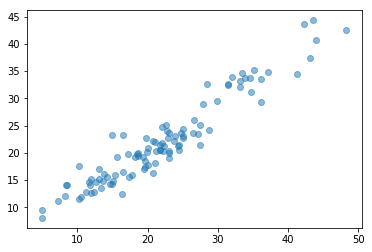

In [189]:
plt.scatter(result.real_MEDV, result.pred_real_MEDV, alpha=0.5)
plt.show()

In [192]:
result.head(30)

,key,MEDV_x,pred_MEDV,real_MEDV,pred_real_MEDV,error
0,139,0.284444,0.243497,17.8,15.957350,1.842650
1,327,0.382222,0.340672,22.2,20.330231,1.869769
2,246,0.428889,0.361512,24.3,21.268055,3.031945
3,477,0.155556,0.168739,12.0,12.593248,-0.593248
4,426,0.115556,0.280725,10.2,17.632633,-7.432633
5,421,0.204444,0.235801,14.2,15.611064,-1.411064
6,157,0.806667,0.653305,41.3,34.398705,6.901295
7,100,0.500000,0.364697,27.5,21.411346,6.088654
8,208,0.431111,0.343144,24.4,20.441460,3.958540
9,132,0.400000,0.312613,23.0,19.067564,3.932436


/root/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


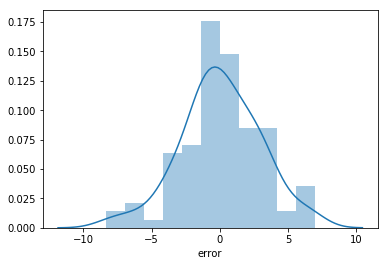

In [191]:
sns.distplot(result['error'])